# JUICE RPWI HF SID2 (RAW): L1a QL -- 2024/8/27

# Import lib

In [ ]:
import copy
import csv
import datetime
import glob
import math
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import sys

# CDF and Directory setting: set by User

In [ ]:
# The latest CDF library https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/latest/
from spacepy import pycdf

import os
os.environ["CDF_LIB"] = "/Applications/cdf/cdf39_1-dist/lib"

# *** Library ***
sys.path.append('./lib/')
import juice_cal_lib  as juice_cal
import juice_cdf_lib  as juice_cdf
import juice_sid2_lib as juice_sid2
import juice_spec_lib as juice_spec

# Setting and Read CDF file: set by User

In [ ]:
# *** Plot dump ***
dump_mode = 0                           # 0: no-dump  1:plot dump
# *** CAL ***
unit_mode = 2                           # [Power]     0: raw     1: V＠ADC     2: V@HF    3: V@RWI  4: V/m
band_mode = 0                           # [Power]     0: sum     1: /Hz
cal_mode  = 2                           # [Power]     0: background     1: CAL     2: all
# *** Unit ***
f_mode    = 1                           # [Frequency] 0: linear  1: log
time_mode = 0                           # [Time]      0: Epoch   1: data number
gap_mode  = 0                           # [gap]       0: n/a     1: gap
# *** Frenquency in Linear ***
f_mode_min = 3000;  f_mode_max = 10000  # 80 - 2068 : as same as SID-4/20
# *** Power range ***
p_raw_max = 7.0                         # background: 7.5   CAL: 10
p_raw_min = 0.0                         # background: 2.5   CAL: 5
# *** Directory set: set by User ***
work_dir = '/Users/user/0-python/JUICE_python/ql/'   # Plot dump folder

In [ ]:
# *** Flight - Ver.2 ***
"""
# 202401
data_dir = '/Users/user/0-python/JUICE_data/Data-CDF/2024/01/25/'
data_name_list = ['JUICE_L1a_RPWI-HF-SID2_20240125T112327_V01.cdf',     # 128   CAL
                 ]
"""
# 202408
data_dir = '/Users/user/Dropbox-Univ/data/data-JUICE/datasets/2024/08/22/'
data_name_list = [#'JUICE_L1a_RPWI-HF-SID2_20240822T023129_V01.cdf',     # 128   CAL
                  'JUICE_L1a_RPWI-HF-SID2_20240822T023715_V01.cdf',
                 ]
"""
"""

In [ ]:
# *** Ground Test - Ver.2 ***
# 202310 -- SAMPLE
data_dir = '/Users/user/0-python/JUICE_data/test-CCSDS/sample/cdf/'
data_name_list = [#'SID02_20231007-0349.cdf',                           # SG - 1.0MHz 10mVpp 90/0/0deg
                  'SID02_20231117-1607.cdf',                            # SG - 1.5MHz 10mVpp 90/0/0deg 
                 ]
"""
data_name_list = ['SID02-high_20231019-1749.cdf',
                  'SID02-high_20231020-1218.cdf',
                  'SID02-high_20231020-1222.cdf',
                 ]
# 202312 -- Checkout
data_dir = '/Users/user/0-python/JUICE_data/test-TMIDX/202312_C/cdf/'
data_name_list = [#'SID02_RPWI_HF_FFT_00000.cdf',
                  #'SID02_RPWI_HF_FFT_00001.cdf',
                  'SID02_RPWI_HF_FFT_00002.cdf',                        # CAL
                  'SID02_RPWI_HF_FFT_00003.cdf',                        # CAL
                  #'SID02_RPWI_HF_FFT_00004.cdf',
                  #'SID02_RPWI_S8_272.cdf',
                 ]
# 202405 -- dryrun      [Num-Frequency: 202    Length: 128     Frequency, width, step (kHz): 191.0 - 44813.0 222.0 222.0]
data_dir = '/Users/user/0-python/JUICE_data/CCSDS_test_v2/test_TMIDX/2405_dryrun_test/1_first_parts/'
data_name_list = ['JUICE_L1a_RPWI-HF-SID2_20000108T044504-20000108T044719_V01___TMIDX_00000.bin.cdf',
                 ]
"""

In [ ]:
# *** Group read
"""
data_dir = '/Users/user/0-python/JUICE_data/test-CCSDS/sample/cdf/'
data_name = 'SID02*.cdf'
cdf_file = data_dir + data_name
data_name_list = glob.glob(cdf_file)
num_list = len(data_name_list)
data_name_list.sort()
for i in range(num_list):
    data_name_list[i] = os.path.split(data_name_list[i])[1]
"""

# get CDF data

In [ ]:
class struct:
    pass

data = struct()
num_list = len(data_name_list)
for i in range(num_list):
    data_name = data_name_list[i];  cdf_file = data_dir + data_name;  print(i, cdf_file)
    cdf = pycdf.CDF(cdf_file);      data1 = juice_sid2.hf_sid2_read(cdf)
    if i==0:
        data = data1;                                print(data.Eu_i.shape)
    else:
        data = juice_sid2.hf_sid2_add(data, data1);  print(data.Eu_i.shape)
data_name = os.path.split(data_name)[1];             print("data name:", data_name)

In [ ]:
data = juice_sid2.hf_sid2_shaping(data, cal_mode)

In [ ]:
print(data.epoch)

In [ ]:
date1 = data.epoch[0];  date1 = date1.strftime('%Y/%m/%d %R:%S')
date2 = data.epoch[-1]; date2 = date2.strftime('%Y/%m/%d %R:%S')
str_date = date1 + "  -  " + date2

n_time0 = data.Eu_i.shape[0];      n_freq0 = data.Eu_i.shape[1];  n_samp0 = data.Eu_i.shape[2]
f_min1  = data.frequency[0][0][0]; f_max1  = max(np.ravel(data.frequency))
N_ch0   = data.U_selected[0] + data.V_selected[0] + data.W_selected[0]

print("       date and time:", str_date)
print("           data size:", data.Eu_i.shape, "  [ Num-samples:", n_time0, "  Num-Frequency:", n_freq0, "  Length:", n_samp0, "]")
print("         Time-length:", data.time[0][0][n_samp0-1], "sec in 1-sweep")
print("f, width, step (kHz):", f_min1,  "-", f_max1, data.freq_width[0][0][0], data.freq_step[0][0][0])
print("                  Ch:", N_ch0, "  [U:", data.U_selected[0], "  V:", data.V_selected[0], "  W:", data.W_selected[0], "]")

# Wave data

In [ ]:
T_HF  = data.T_HF_FPGA[n_time0//2];  T_RWI = (data.T_RWI_CH1[n_time0//2] + data.T_RWI_CH2[n_time0//2])/2
if T_HF  > 199 or T_HF  < -50:
   T_HF  = 25;  data.T_HF_FPGA[:] = math.nan
if T_RWI > 199 or T_RWI < -200:
   T_RWI = 25;  data.T_RWI_CH1[:] = math.nan;  data.T_RWI_CH2[:] = math.nan

In [ ]:
wave = juice_cal.wave_cal(data, 2, unit_mode, T_HF, T_RWI)
p_max0 = p_raw_max + wave.cf/10;     p_min0 = p_raw_min + wave.cf/10

print("unit_mode:", unit_mode, "  conversion factor:", '{:.1f}'.format(wave.cf), 
      "  MAX-min:", '{:.1f}'.format(p_max0), '{:.1f}'.format(p_min0), "  str_unit:", wave.str, 
      "  T-HF & T-RWI:", T_HF, "(", data.T_HF_FPGA[n_time0//2], ")", T_RWI, "(", data.T_RWI_CH1[n_time0//2], ")")

In [ ]:
print("decimation:", juice_cdf._sample_rate(data.decimation[0]))
print("Peak Eu:", '{:.2e} V'.format(np.amax(wave.Eu_i)), ' {:.2e} V'.format(np.amax(wave.Eu_q)))
print("Peak Ev:", '{:.2e} V'.format(np.amax(wave.Ev_i)), ' {:.2e} V'.format(np.amax(wave.Ev_q)))
print("Peak Ew:", '{:.2e} V'.format(np.amax(wave.Ew_i)), ' {:.2e} V'.format(np.amax(wave.Ew_q)))

In [ ]:
fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(6, 1, 1);  ax2 = fig.add_subplot(6, 1, 2);  ax3 = fig.add_subplot(6, 1, 3)
ax4 = fig.add_subplot(6, 1, 4);  ax5 = fig.add_subplot(6, 1, 5);  ax6 = fig.add_subplot(6, 1, 6)

ax1.plot(np.ravel(wave.Eu_i[:][:]), '-r', linewidth=.5, label='Eu_i'); ax1.plot(np.ravel(wave.Eu_q[:][:]), ':g', linewidth=.5, label='Eu_q')
ax2.plot(np.ravel(wave.Ev_i[:][:]), '-r', linewidth=.5, label='Ev_i'); ax2.plot(np.ravel(wave.Ev_q[:][:]), ':g', linewidth=.5, label='Ev_q')
ax3.plot(np.ravel(wave.Ew_i[:][:]), '-r', linewidth=.5, label='Ew_i'); ax3.plot(np.ravel(wave.Ew_q[:][:]), ':g', linewidth=.5, label='Ew_q')
ax4.plot(np.ravel(data.frequency),     '-b', linewidth=.5,  label='Frequency')
ax4.plot(np.ravel(data.freq_step*10),  '-g', linewidth=0.8, label='step*10')
ax4.plot(np.ravel(data.freq_width*10), ':b', linewidth=1.0, label='width*10')
ax4.plot(np.ravel(data.sweep_start)*data.frequency[0][-1][0], '-r', linewidth=.5, label='Sweep Start')
ax5.plot(np.ravel(data.T_HF_FPGA),  ':r', label='T (HK-FPGA)');  ax5.plot(np.ravel(data.T_RWI_CH1),     ':b', label='T (RWI1)');  
ax5.plot(np.ravel(data.T_RWI_CH2),  ':g', label='T (RWI2)');     ax5.plot(np.ravel(data.cal_signal*10), '-k', label='CAL-Singal')
ax6.plot(np.ravel(data.epoch[:]), '.')

ax1.set_ylabel('Eu '+wave.str);     ax2.set_ylabel('Ev '+wave.str);  ax3.set_ylabel('Ew '+wave.str);  
ax4.set_ylabel('Frequency [kHz]');  ax5.set_ylabel('T [degC]');      ax6.set_xlabel(str_date)
title_label = '[JUICE/RPWI HF RAW (SID-2)]  ' + data_name;           ax1.set_title(title_label)
ax1.legend(loc='upper right', fontsize=8);  ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8)
ax4.legend(loc='upper right', fontsize=8);  ax5.legend(loc='upper right', fontsize=8)

xlim=[-0.5, len(np.ravel(data.Eu_i[:][:])) -0.5];  ax1.set_xlim(xlim);  ax2.set_xlim(xlim);  ax3.set_xlim(xlim);  ax4.set_xlim(xlim)
xlim=[-0.5, n_time0                        -0.5];  ax5.set_xlim(xlim);  ax6.set_xlim(xlim)
p_max = np.ceil(np.log10(np.amax([np.amax(wave.Eu_i), np.amax(wave.Eu_q), np.amax(wave.Ev_i), np.amax(wave.Ev_q), np.amax(wave.Ew_i), np.amax(wave.Ew_q)]))*5)/5
ylim=[-10**(p_max), 10**(p_max)];  ax1.set_ylim(ylim);  ax2.set_ylim(ylim);  ax3.set_ylim(ylim)
ylim=[f_min1, f_max1];             ax4.set_ylim(ylim)

# Plot
fig.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'_raw.png'
    fig.savefig(png_fname)

### WAVE - First 3 Sweeps

In [ ]:
num_sweep = 3;  n_sweep0 = n_time0//2;  n_sweep1 = n_sweep0 + num_sweep;  print("[specific sweep]  SWEEP:", n_sweep0, n_sweep1, "in total of", n_time0)
f_min = f_min1;  f_max = f_max1

fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(5, 1, 1);  ax2 = fig.add_subplot(5, 1, 2);  ax3 = fig.add_subplot(5, 1, 3);  ax4 = fig.add_subplot(5, 1, 4);  ax5 = fig.add_subplot(5, 1, 5)

ax1.plot(np.ravel(wave.Eu_i[n_sweep0:n_sweep1]), '-r', linewidth=.5, label='Eu_i');  ax1.plot(np.ravel(wave.Eu_q[n_sweep0:n_sweep1]), ':g', linewidth=.5, label='Eu_q')
ax2.plot(np.ravel(wave.Ev_i[n_sweep0:n_sweep1]), '-r', linewidth=.5, label='Ev_i');  ax2.plot(np.ravel(wave.Ev_q[n_sweep0:n_sweep1]), ':g', linewidth=.5, label='Ev_q')
ax3.plot(np.ravel(wave.Ew_i[n_sweep0:n_sweep1]), '-r', linewidth=.5, label='Ew_i');  ax3.plot(np.ravel(wave.Ew_q[n_sweep0:n_sweep1]), ':g', linewidth=.5, label='Ew_q')
ax4.plot(np.ravel(data.frequency[n_sweep0:n_sweep1]),     '-b', linewidth=.5,  label='Frequency')
ax4.plot(np.ravel(data.freq_step[n_sweep0:n_sweep1]*10),  '-g', linewidth=0.8, label='step*10')
ax4.plot(np.ravel(data.freq_width[n_sweep0:n_sweep1]*10), ':b', linewidth=1.0, label='width*10')
ax4.plot(np.ravel(data.sweep_start[n_sweep0:n_sweep1])*data.frequency[n_sweep0][-1][0], '-r', label='Sweep Start')
ax5.plot(np.ravel(data.epoch[n_sweep0:n_sweep1+1]), '.')

date1 = data.epoch[n_sweep0];  date1 = date1.strftime('%Y/%m/%d %R:%S');  ax5.set_xlabel(date1)
ax1.set_ylabel('Eu '+wave.str);  ax2.set_ylabel('Ev '+wave.str);  ax3.set_ylabel('Ew '+wave.str);  ax4.set_ylabel('Frequency [kHz]');  
title_label = '[JUICE/RPWI HF RAW (SID-2)]  ' + data_name;  ax1.set_title(title_label)
ax1.legend(loc='upper right', fontsize=8);  ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8)
ax4.legend(loc='upper right', fontsize=8)

xlim=[-0.5, len(np.ravel(data.Eu_i[n_sweep0:n_sweep1])) -0.5]; ax1.set_xlim(xlim); ax2.set_xlim(xlim); ax3.set_xlim(xlim); ax4.set_xlim(xlim)
xlim=[-0.5, num_sweep                                   -0.5]; ax5.set_xlim(xlim)
p_max = np.ceil(np.log10( np.amax( [np.amax(wave.Eu_i[n_sweep0:n_sweep1]), np.amax(wave.Eu_q[n_sweep0:n_sweep1]), np.amax(wave.Ev_i[n_sweep0:n_sweep1]), np.amax(wave.Ev_q[n_sweep0:n_sweep1]), np.amax(wave.Ew_i[n_sweep0:n_sweep1]), np.amax(wave.Ew_q[n_sweep0:n_sweep1])] ) )*5)/5
ylim=[-10**(p_max), 10**(p_max)]; ax1.set_ylim(ylim);  ax2.set_ylim(ylim);  ax3.set_ylim(ylim)
ylim=[f_min, f_max]; ax4.set_ylim(ylim)

fig.subplots_adjust(hspace=0);  fig.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'_raw-sweep.png'
    fig.savefig(png_fname)

### WAVE - First 3 steps

In [ ]:
num_step = 3;  n_sweep = n_time0//2;  n_step0 = 5;  n_step1 = n_step0 + num_step;  print("[specific sweep]  SWEEP:", n_sweep, "in total of", n_time0,  "[Steps]", n_step0, "-", n_step1)
fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(4, 1, 1);  ax2 = fig.add_subplot(4, 1, 2);  ax3 = fig.add_subplot(4, 1, 3);  ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(np.ravel(wave.Eu_i[n_sweep][n_step0:n_step1]), '-r', linewidth=.5, label='Eu_i');  ax1.plot(np.ravel(wave.Eu_q[n_sweep][n_step0:n_step1]), ':g', linewidth=.5, label='Eu_q')
ax2.plot(np.ravel(wave.Ev_i[n_sweep][n_step0:n_step1]), '-r', linewidth=.5, label='Ev_i');  ax2.plot(np.ravel(wave.Ev_q[n_sweep][n_step0:n_step1]), ':g', linewidth=.5, label='Ev_q')
ax3.plot(np.ravel(wave.Ew_i[n_sweep][n_step0:n_step1]), '-r', linewidth=.5, label='Ew_i');  ax3.plot(np.ravel(wave.Ew_q[n_sweep][n_step0:n_step1]), ':g', linewidth=.5, label='Ew_q')
ax4.plot(np.ravel(data.frequency[n_sweep][n_step0:n_step1]),     '-b', linewidth=.5, label='Frequency')
ax4.plot(np.ravel(data.sweep_start[n_sweep][n_step0:n_step1])*data.frequency[n_sweep][n_step1][0], '-r', label='Sweep Start')

date1 = data.epoch[n_sweep];  date1 = date1.strftime('%Y/%m/%d %R:%S');  ax4.set_xlabel(date1)
ax1.set_ylabel('Eu '+wave.str);  ax2.set_ylabel('Ev '+wave.str);  ax3.set_ylabel('Ew '+wave.str);  ax4.set_ylabel('Frequency [kHz]');  
title_label = '[JUICE/RPWI HF RAW (SID-2)]  ' + data_name;  ax1.set_title(title_label)
ax1.legend(loc='upper right', fontsize=8);  ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8)
ax4.legend(loc='upper right', fontsize=8)

xlim=[-0.5, len(np.ravel(data.Eu_i[n_sweep][n_step0:n_step1])) -0.5];  ax1.set_xlim(xlim);  ax2.set_xlim(xlim);  ax3.set_xlim(xlim);  ax4.set_xlim(xlim)
p_max = np.ceil(np.log10( np.amax( [np.amax(wave.Eu_i[n_sweep][n_step0:n_step1]), np.amax(wave.Eu_q[n_sweep][n_step0:n_step1]), np.amax(wave.Ev_i[n_sweep][n_step0:n_step1]), np.amax(wave.Ev_q[n_sweep][n_step0:n_step1]), np.amax(wave.Ew_i[n_sweep][n_step0:n_step1]), np.amax(wave.Ew_q[n_sweep][n_step0:n_step1])] ) )*5)/5
ylim=[-10**(p_max), 10**(p_max)]; ax1.set_ylim(ylim);  ax2.set_ylim(ylim);  ax3.set_ylim(ylim)

# Plot
fig.subplots_adjust(hspace=0)
fig.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'_raw-step.png'
    fig.savefig(png_fname)

# Spectrum Data

In [ ]:
spec = juice_spec.hf_getspec_sid2(data, cal_mode)                       # Wave -> Spectrum
Epoch_1d  = spec.epoch.tolist();    n_time1 = spec.EuEu.shape[0];  num_1d = np.arange(n_time1)
freq_1d   = spec.freq[n_time1//2];  n_freq0 = freq_1d.shape[0];    f_min0 = freq_1d[0];  f_max0  = freq_1d[-1]
freq_w_1d = spec.freq_w[n_time1//2]

In [ ]:
spec = juice_cal.spec_cal(spec, 2, unit_mode, band_mode, T_HF, T_RWI)   # CAL
spec = juice_spec.hf_getspec_angle(spec)                                # Coherency & ange
spec = juice_spec.hf_getspec_stokes(spec)                               # Stokes and Polarization Parameters 

In [ ]:
print("Peak Eu:", '{:.2e} V'.format(np.amax(wave.Eu_i)), ' {:.2e} V'.format(np.amax(wave.Eu_q)))
print("Peak Ev:", '{:.2e} V'.format(np.amax(wave.Ev_i)), ' {:.2e} V'.format(np.amax(wave.Ev_q)))
print("Peak Ew:", '{:.2e} V'.format(np.amax(wave.Ew_i)), ' {:.2e} V'.format(np.amax(wave.Ew_q)))
peak_E = np.ravel(spec.EuEu[:][:]); peak_f = np.argmax(peak_E); print("Peak EuEu:", '{:.2e}'.format(peak_E[peak_f]), '{:.2e}'.format(peak_E[peak_f]**.5), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])**.5))
peak_E = np.ravel(spec.EvEv[:][:]); peak_f = np.argmax(peak_E); print("Peak EvEv:", '{:.2e}'.format(peak_E[peak_f]), '{:.2e}'.format(peak_E[peak_f]**.5), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])**.5))
peak_E = np.ravel(spec.EwEw[:][:]); peak_f = np.argmax(peak_E); print("Peak EwEw:", '{:.2e}'.format(peak_E[peak_f]), '{:.2e}'.format(peak_E[peak_f]**.5), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])**.5))

In [ ]:
n_sweep1 = 0;  n_sweep2 = n_time1//2;  n_sweep3 = n_time1-1
print(f"[First peak - {n_sweep1}]")
peak_E = np.ravel(spec.EuEu[n_sweep1]); peak_f = np.argmax(peak_E); print("EuEu:", '{:.2e} V2 '.format(peak_E[peak_f]), '{:.2e} V '.format(peak_E[peak_f]**.5), '{:.1f} kHz'.format(freq_1d[peak_f]))
peak_E = np.ravel(spec.EvEv[n_sweep1]); peak_f = np.argmax(peak_E); print("EvEv:", '{:.2e} V2 '.format(peak_E[peak_f]), '{:.2e} V '.format(peak_E[peak_f]**.5), '{:.1f} kHz'.format(freq_1d[peak_f]))
peak_E = np.ravel(spec.EwEw[n_sweep1]); peak_f = np.argmax(peak_E); print("EwEw:", '{:.2e} V2 '.format(peak_E[peak_f]), '{:.2e} V '.format(peak_E[peak_f]**.5), '{:.1f} kHz'.format(freq_1d[peak_f]))
print(f"[Mid   peak - {n_sweep2}]")
peak_E = np.ravel(spec.EuEu[n_sweep2]); peak_f = np.argmax(peak_E); print("EuEu:", '{:.2e} V2 '.format(peak_E[peak_f]), '{:.2e} V '.format(peak_E[peak_f]**.5), '{:.1f} kHz'.format(freq_1d[peak_f]))
peak_E = np.ravel(spec.EvEv[n_sweep2]); peak_f = np.argmax(peak_E); print("EvEv:", '{:.2e} V2 '.format(peak_E[peak_f]), '{:.2e} V '.format(peak_E[peak_f]**.5), '{:.1f} kHz'.format(freq_1d[peak_f]))
peak_E = np.ravel(spec.EwEw[n_sweep2]); peak_f = np.argmax(peak_E); print("EwEw:", '{:.2e} V2 '.format(peak_E[peak_f]), '{:.2e} V '.format(peak_E[peak_f]**.5), '{:.1f} kHz'.format(freq_1d[peak_f]))
print(f"[Last  peak - {n_sweep3}]")
peak_E = np.ravel(spec.EuEu[n_sweep3]); peak_f = np.argmax(peak_E); print("EuEu:", '{:.2e} V2 '.format(peak_E[peak_f]), '{:.2e} V '.format(peak_E[peak_f]**.5), '{:.1f} kHz'.format(freq_1d[peak_f]))
peak_E = np.ravel(spec.EvEv[n_sweep3]); peak_f = np.argmax(peak_E); print("EvEv:", '{:.2e} V2 '.format(peak_E[peak_f]), '{:.2e} V '.format(peak_E[peak_f]**.5), '{:.1f} kHz'.format(freq_1d[peak_f]))
peak_E = np.ravel(spec.EwEw[n_sweep3]); peak_f = np.argmax(peak_E); print("EwEw:", '{:.2e} V2 '.format(peak_E[peak_f]), '{:.2e} V '.format(peak_E[peak_f]**.5), '{:.1f} kHz'.format(freq_1d[peak_f]))

In [ ]:
EuEu_2d    = spec.EuEu.transpose();     EuEu_med    = np.nanmedian(spec.EuEu,    axis=0)
EvEv_2d    = spec.EvEv.transpose();     EvEv_med    = np.nanmedian(spec.EvEv,    axis=0)
EwEw_2d    = spec.EwEw.transpose();     EwEw_med    = np.nanmedian(spec.EwEw,    axis=0)
E_DoPuv_2d = spec.E_DoPuv.transpose();  E_DoPuv_med = np.nanmedian(spec.E_DoPuv, axis=0)
E_DoPvw_2d = spec.E_DoPvw.transpose();  E_DoPvw_med = np.nanmedian(spec.E_DoPvw, axis=0)
E_DoPwu_2d = spec.E_DoPwu.transpose();  E_DoPwu_med = np.nanmedian(spec.E_DoPwu, axis=0)
E_DoLuv_2d = spec.E_DoLuv.transpose();  E_DoLuv_med = np.nanmedian(spec.E_DoLuv, axis=0)
E_DoLvw_2d = spec.E_DoLvw.transpose();  E_DoLvw_med = np.nanmedian(spec.E_DoLvw, axis=0)
E_DoLwu_2d = spec.E_DoLwu.transpose();  E_DoLwu_med = np.nanmedian(spec.E_DoLwu, axis=0)
E_DoCuv_2d = spec.E_DoCuv.transpose();  E_DoCuv_med = np.nanmedian(spec.E_DoCuv, axis=0)
E_DoCvw_2d = spec.E_DoCvw.transpose();  E_DoCvw_med = np.nanmedian(spec.E_DoCvw, axis=0)
E_DoCwu_2d = spec.E_DoCwu.transpose();  E_DoCwu_med = np.nanmedian(spec.E_DoCwu, axis=0)
E_ANGuv_2d = spec.E_ANGuv.transpose();  E_ANGuv_med = np.nanmedian(spec.E_ANGuv, axis=0)
E_ANGvw_2d = spec.E_ANGvw.transpose();  E_ANGvw_med = np.nanmedian(spec.E_ANGvw, axis=0)
E_ANGwu_2d = spec.E_ANGwu.transpose();  E_ANGwu_med = np.nanmedian(spec.E_ANGwu, axis=0)
E_COHuv_2d = spec.E_COHuv.transpose();  E_COHuv_med = np.nanmedian(spec.E_COHuv, axis=0)
E_COHvw_2d = spec.E_COHvw.transpose();  E_COHvw_med = np.nanmedian(spec.E_COHvw, axis=0)
E_COHwu_2d = spec.E_COHwu.transpose();  E_COHwu_med = np.nanmedian(spec.E_COHwu, axis=0)
E_PHAuv_2d = spec.E_PHAuv.transpose();  E_PHAuv_med = np.nanmedian(spec.E_PHAuv, axis=0)
E_PHAvw_2d = spec.E_PHAvw.transpose();  E_PHAvw_med = np.nanmedian(spec.E_PHAvw, axis=0)
E_PHAwu_2d = spec.E_PHAwu.transpose();  E_PHAwu_med = np.nanmedian(spec.E_PHAwu, axis=0)
spec.EE = spec.EuEu + spec.EvEv + spec.EwEw; EE_med = np.nanmedian(spec.EE,     axis=0)

p_max1 = p_raw_max + spec.cf/10; p_min1 = p_raw_min + spec.cf/10
p_max1 = np.ceil(np.log10(np.amax([np.amax(spec.EuEu), np.amax(spec.EvEv), np.amax(spec.EwEw)]))*5)/5
print(spec.str, "[EE]", spec.EuEu.shape, "[frequency]", freq_1d[0], "-", freq_1d[-1], "kHz  (df =", freq_w_1d[0], "kHz)")
print("unit_mode:", unit_mode, "  conversion factor:", '{:.1f}'.format(spec.cf), "[wave:", '{:.1f}'.format(wave.cf),
      "]  MAX-min:", '{:.1f}'.format(p_max1), '{:.1f}'.format(p_min1), 
      "  T-HF & T-RWI:", T_HF, "(", data.T_HF_FPGA[n_time0//2], ")", T_RWI, "(", data.T_RWI_CH1[n_time0//2], ")")

In [ ]:
n_sweep = n_time1//2;  peak_E = np.ravel(spec.EuEu[n_sweep]); peak_f = np.argmax(peak_E); 
print(f"[SWEEP - {n_sweep}]  Peak at", '{:.1f}'.format(freq_1d[peak_f]), "kHz", peak_f)
print("      EuEu:", '{:+.2e} V2'.format(np.ravel(spec.EuEu   [n_sweep])[peak_f]), "     EvEv:", '{:+.2e} V2'.format(np.ravel(spec.EvEv   [n_sweep])[peak_f]), "   EwEw:", '{:+.2e} V2'.format(np.ravel(spec.EwEw   [n_sweep])[peak_f]))
print("   EuEv_re:", '{:+.2e} V2'.format(np.ravel(spec.EuEv_re[n_sweep])[peak_f]), "  EuEv_im:", '{:+.2e} V2'.format(np.ravel(spec.EuEv_im[n_sweep])[peak_f]), "  PHAuv:", '{:+5.1f} deg'.format(np.ravel(spec.E_PHAuv[n_sweep])[peak_f]), "  COHuv:", '{:+4.2f}'.format(np.ravel(spec.E_COHuv[n_sweep])[peak_f]), "  DoPuv:", '{:+4.2f}'.format(np.ravel(spec.E_DoPuv[n_sweep])[peak_f]), "  DoLuv:", '{:+4.2f}'.format(np.ravel(spec.E_DoLuv[n_sweep])[peak_f]), "  DoCuv:", '{:+4.2f}'.format(np.ravel(spec.E_DoCuv[n_sweep])[peak_f]), "  ANGuv:", '{:+5.1f} deg'.format(np.ravel(spec.E_ANGuv[n_sweep])[peak_f]))
print("   EvEw_re:", '{:+.2e} V2'.format(np.ravel(spec.EvEw_re[n_sweep])[peak_f]), "  EvEw_im:", '{:+.2e} V2'.format(np.ravel(spec.EvEw_im[n_sweep])[peak_f]), "  PHAvw:", '{:+5.1f} deg'.format(np.ravel(spec.E_PHAvw[n_sweep])[peak_f]), "  COHvw:", '{:+4.2f}'.format(np.ravel(spec.E_COHvw[n_sweep])[peak_f]), "  DoPvw:", '{:+4.2f}'.format(np.ravel(spec.E_DoPvw[n_sweep])[peak_f]), "  DoLvw:", '{:+4.2f}'.format(np.ravel(spec.E_DoLvw[n_sweep])[peak_f]), "  DoCvw:", '{:+4.2f}'.format(np.ravel(spec.E_DoCvw[n_sweep])[peak_f]), "  ANGvw:", '{:+5.1f} deg'.format(np.ravel(spec.E_ANGvw[n_sweep])[peak_f]))
print("   EwEu_re:", '{:+.2e} V2'.format(np.ravel(spec.EwEu_re[n_sweep])[peak_f]), "  EwEu_im:", '{:+.2e} V2'.format(np.ravel(spec.EwEu_im[n_sweep])[peak_f]), "  PHAwu:", '{:+5.1f} deg'.format(np.ravel(spec.E_PHAwu[n_sweep])[peak_f]), "  COHqu:", '{:+4.2f}'.format(np.ravel(spec.E_COHwu[n_sweep])[peak_f]), "  DoPwu:", '{:+4.2f}'.format(np.ravel(spec.E_DoPwu[n_sweep])[peak_f]), "  DoLwu:", '{:+4.2f}'.format(np.ravel(spec.E_DoLwu[n_sweep])[peak_f]), "  DoCwu:", '{:+4.2f}'.format(np.ravel(spec.E_DoCwu[n_sweep])[peak_f]), "  ANGwu:", '{:+5.1f} deg'.format(np.ravel(spec.E_ANGwu[n_sweep])[peak_f]))
#print('Stockes-UV: {:+.2e}'.format(np.ravel(spec.E_Iuv[n_sweep])[peak_f]),   '{:+.2e}'.format(np.ravel(spec.E_Quv[n_sweep])[peak_f]),   '{:+.2e}'.format(np.ravel(spec.E_Uuv[n_sweep])[peak_f]),   '{:+.2e}'.format(np.ravel(spec.E_Vuv[n_sweep])[peak_f]))
#print('Stockes-VW: {:+.2e}'.format(np.ravel(spec.E_Ivw[n_sweep])[peak_f]),   '{:+.2e}'.format(np.ravel(spec.E_Qvw[n_sweep])[peak_f]),   '{:+.2e}'.format(np.ravel(spec.E_Uvw[n_sweep])[peak_f]),   '{:+.2e}'.format(np.ravel(spec.E_Vvw[n_sweep])[peak_f]))
#print('Stockes-WU: {:+.2e}'.format(np.ravel(spec.E_Iwu[n_sweep])[peak_f]),   '{:+.2e}'.format(np.ravel(spec.E_Qwu[n_sweep])[peak_f]),   '{:+.2e}'.format(np.ravel(spec.E_Uwu[n_sweep])[peak_f]),   '{:+.2e}'.format(np.ravel(spec.E_Vwu[n_sweep])[peak_f]))

In [ ]:
n_sweep1 = n_time1//4;  n_sweep2 = n_time1//2;  n_sweep3 = n_time1-1
p_min = p_min1;  p_max = p_max1
if cal_mode == 1:
    p_max = p_max+2    
f_min = f_min0;  f_max = f_max0
# f_min = 1500;  f_max = 1600
if f_mode == 0:
    f_min = f_mode_min;  f_max = f_mode_max;  print(data.frequency[0][0][0], data.frequency[0][8][0])

fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(3, 1, 1);  ax2 = fig.add_subplot(3, 1, 2);  ax3 = fig.add_subplot(3, 1, 3)

ax1.plot(freq_1d, spec.EuEu[n_sweep1], '-r', linewidth=.9, label='EuEu 1st')
ax1.plot(freq_1d, spec.EuEu[n_sweep2], '-g', linewidth=.4, label='EuEu mid')
ax1.plot(freq_1d, spec.EuEu[n_sweep3], '-b', linewidth=.2, label='EuEu last')
ax2.plot(freq_1d, spec.EvEv[n_sweep1], '-r', linewidth=.9, label='EvEv 1st')
ax2.plot(freq_1d, spec.EvEv[n_sweep2], '-g', linewidth=.4, label='EvEv mid')
ax2.plot(freq_1d, spec.EvEv[n_sweep3], '-b', linewidth=.2, label='EvEv last')
ax3.plot(freq_1d, spec.EwEw[n_sweep1], '-r', linewidth=.9, label='EwEw 1st')
ax3.plot(freq_1d, spec.EwEw[n_sweep2], '-g', linewidth=.4, label='EwEw mid')
ax3.plot(freq_1d, spec.EwEw[n_sweep3], '-b', linewidth=.2, label='EwEw last')
ax1.set_yscale('log');      ax2.set_yscale('log');  ax3.set_yscale('log')
if f_mode == 1:
    ax1.set_xscale('log');  ax2.set_xscale('log');  ax3.set_xscale('log')
ax1.set_ylabel('EuEu '+spec.str);     ax2.set_ylabel('EvEv '+spec.str); ax3.set_ylabel('EwEw '+spec.str);  ax3.set_xlabel('Frequency [kHz]')

date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime('1st: %Y/%m/%d %R:%S   ')
date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime('Mid: %Y/%m/%d %R:%S   ')
date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime('Fin: %Y/%m/%d %R:%S')
title_date = date1 + "  -  " + date2 + "  -  " + date3;   ax1.set_title(title_date)
ax1.legend(loc='upper right', fontsize=8);  ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8)

xlim=[f_min, f_max]
ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim)
# p_max = np.ceil(np.log10(np.nanmax([np.nanmax(spec.EuEu), np.nanmax(spec.EvEv), np.nanmax(spec.EwEw)]))*10)/10
ylim=[10**(p_min), 10**(p_max)]
ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim)

fig.subplots_adjust(hspace=0)
fig.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'_spec.png'
    if f_mode == 1:
        png_fname = work_dir+data_name+'_spec-log.png'
    fig.savefig(png_fname)

In [ ]:
n_sweep1 = n_time1//4;  n_sweep2 = n_time1//2;  n_sweep3 = n_time1-1
p_min = p_min1;  p_max = p_max1
if cal_mode == 1:
    p_max = p_max+2    
f_min = 0;       f_max = 5000

fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(9, 1, 1);  ax2 = fig.add_subplot(9, 1, 2);  ax3 = fig.add_subplot(9, 1, 3);  ax4 = fig.add_subplot(9, 1, 4)
ax5 = fig.add_subplot(9, 1, 5);  ax6 = fig.add_subplot(9, 1, 6);  ax7 = fig.add_subplot(9, 1, 7);  ax8 = fig.add_subplot(9, 1, 8);  ax9 = fig.add_subplot(9, 1, 9)

ax1.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.7, label='EE 1st'); ax1.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.7, label='EE med')
ax1.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.7, label='EE fin'); ax1.plot(freq_1d, EE_med,            '-k', linewidth=.7, label='EE ave')
ax2.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.7, label='EE 1st'); ax2.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.7, label='EE med')
ax2.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.7, label='EE fin'); ax2.plot(freq_1d, EE_med,            '-k', linewidth=.7, label='EE ave')
ax3.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.7, label='EE 1st'); ax3.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.7, label='EE med')
ax3.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.7, label='EE fin'); ax3.plot(freq_1d, EE_med,            '-k', linewidth=.7, label='EE ave')
ax4.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.7, label='EE 1st'); ax4.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.7, label='EE med')
ax4.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.7, label='EE fin'); ax4.plot(freq_1d, EE_med,            '-k', linewidth=.7, label='EE ave')
ax5.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.7, label='EE 1st'); ax5.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.7, label='EE med')
ax5.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.7, label='EE fin'); ax5.plot(freq_1d, EE_med,            '-k', linewidth=.7, label='EE ave')
ax6.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.7, label='EE 1st'); ax6.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.7, label='EE med')
ax6.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.7, label='EE fin'); ax6.plot(freq_1d, EE_med,            '-k', linewidth=.7, label='EE ave')
ax7.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.7, label='EE 1st'); ax7.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.7, label='EE med')
ax7.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.7, label='EE fin'); ax7.plot(freq_1d, EE_med,            '-k', linewidth=.7, label='EE ave')
ax8.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.7, label='EE 1st'); ax8.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.7, label='EE med')
ax8.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.7, label='EE fin'); ax8.plot(freq_1d, EE_med,            '-k', linewidth=.7, label='EE ave')
ax9.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.7, label='EE 1st'); ax9.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.7, label='EE med')
ax9.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.7, label='EE fin'); ax9.plot(freq_1d, EE_med,            '-k', linewidth=.7, label='EE ave')
ax1.set_yscale('log');  ax2.set_yscale('log');  ax3.set_yscale('log');  ax4.set_yscale('log');  ax5.set_yscale('log')
ax6.set_yscale('log');  ax7.set_yscale('log');  ax8.set_yscale('log');  ax9.set_yscale('log')

# Label
ax1.set_ylabel(spec.str); ax2.set_ylabel(spec.str); ax3.set_ylabel(spec.str); ax4.set_ylabel(spec.str); ax5.set_ylabel(spec.str)
ax6.set_ylabel(spec.str); ax7.set_ylabel(spec.str); ax8.set_ylabel(spec.str); ax9.set_ylabel(spec.str)
ax9.set_xlabel('Frequency [kHz]')
#
date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime(f'1st {n_sweep1}: %Y/%m/%d %R:%S ')
date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime(f'Mid {n_sweep2}: %Y/%m/%d %R:%S ')
date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime(f'Fin {n_sweep3}: %Y/%m/%d %R:%S')
title_date = date1 + "  -  " + date2 + "  -  " + date3
ax1.set_title(title_date)

ax1.legend(loc='upper right', fontsize=8);  ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8)
ax4.legend(loc='upper right', fontsize=8);  ax5.legend(loc='upper right', fontsize=8);  ax6.legend(loc='upper right', fontsize=8)
ax7.legend(loc='upper right', fontsize=8);  ax8.legend(loc='upper right', fontsize=8);  ax9.legend(loc='upper right', fontsize=8)

xlim=[f_min,       f_max];        ax1.set_xlim(xlim); xlim=[f_min+5000,  f_max+5000];   ax2.set_xlim(xlim);  
xlim=[f_min+10000, f_max+10000];  ax3.set_xlim(xlim); xlim=[f_min+15000, f_max+15000];  ax4.set_xlim(xlim)
xlim=[f_min+20000, f_max+20000];  ax5.set_xlim(xlim); xlim=[f_min+25000, f_max+25000];  ax6.set_xlim(xlim)
xlim=[f_min+30000, f_max+30000];  ax7.set_xlim(xlim); xlim=[f_min+35000, f_max+35000];  ax8.set_xlim(xlim)
xlim=[f_min+40000, f_max+40000];  ax9.set_xlim(xlim); 
ax1.tick_params(labelsize=7); ax2.tick_params(labelsize=7); ax3.tick_params(labelsize=7); ax4.tick_params(labelsize=7); ax5.tick_params(labelsize=7)
ax6.tick_params(labelsize=7); ax7.tick_params(labelsize=7); ax8.tick_params(labelsize=7); ax9.tick_params(labelsize=7)

ylim=[10**p_min, 10**p_max]
ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim); ax5.set_ylim(ylim); ax6.set_ylim(ylim);  
ax7.set_ylim(ylim); ax8.set_ylim(ylim);  ax9.set_ylim(ylim)

fig.subplots_adjust(hspace=0.2)
fig.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'_spec-fine.png'
    fig.savefig(png_fname)

### GAP: fill NaN

In [ ]:
if gap_mode == 1:
    for i in range(n_time0-1):
        if data.scet[i+1]-data.scet[i] > 60:
            print(i, data.epoch[i], i+1, data.epoch[i+1])
            spec.EE[i]      = math.nan;                                                            spec.EE[i+1]      = math.nan
            spec.EuEu[i]    = math.nan;  spec.EvEv[i]    = math.nan;  spec.EwEw[i]    = math.nan;  spec.EuEu[i+1]    = math.nan;  spec.EvEv[i+1]    = math.nan;  spec.EwEw[i+1]    = math.nan
            spec.E_DoLuv[i] = math.nan;  spec.E_DoLvw[i] = math.nan;  spec.E_DoLwu[i] = math.nan;  spec.E_DoLuv[i+1] = math.nan;  spec.E_DoLvw[i+1] = math.nan;  spec.E_DoLwu[i+1] = math.nan
            spec.E_DoCuv[i] = math.nan;  spec.E_DoCvw[i] = math.nan;  spec.E_DoCwu[i] = math.nan;  spec.E_DoCuv[i+1] = math.nan;  spec.E_DoCvw[i+1] = math.nan;  spec.E_DoCwu[i+1] = math.nan
            spec.E_ANGuv[i] = math.nan;  spec.E_ANGvw[i] = math.nan;  spec.E_ANGwu[i] = math.nan;  spec.E_ANGuv[i+1] = math.nan;  spec.E_ANGvw[i+1] = math.nan;  spec.E_ANGwu[i+1] = math.nan

In [ ]:
p_min = p_min1;  p_max = p_max1
f_min = f_min0;      f_max = f_max0
if f_mode == 0:
    f_min = f_mode_min;  f_max = f_mode_max;  print(data.frequency[0][0][0], data.frequency[0][8][0])

fig2d = plt.figure(figsize=[16,11])
if time_mode == 1:
    ax1 = fig2d.add_subplot(4, 1, 1); ax2 = fig2d.add_subplot(4, 1, 2); ax3 = fig2d.add_subplot(4, 1, 3); ax4.set_xlabel(str_date); ax4 = fig2d.add_subplot(4, 1, 4)
else:
    ax1 = fig2d.add_subplot(3, 1, 1); ax2 = fig2d.add_subplot(3, 1, 2); ax3 = fig2d.add_subplot(3, 1, 3);                           ax3.set_xlabel(str_date)

ax1.set_ylabel('EuEu [kHz]');     ax2.set_ylabel('EvEv [kHz]');     ax3.set_ylabel('EwEw [kHz]')
ax1.set_ylim(f_min, f_max); ax2.set_ylim(f_min, f_max); ax3.set_ylim(f_min, f_max)
if f_mode == 1:
    ax1.set_yscale('log');        ax2.set_yscale('log');        ax3.set_yscale('log')

if time_mode == 1:
    p1 = ax1.pcolormesh(num_1d, freq_1d, EuEu_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p2 = ax2.pcolormesh(num_1d, freq_1d, EvEv_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p3 = ax3.pcolormesh(num_1d, freq_1d, EwEw_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p4 = ax4.plot(np.ravel(spec.epoch[:]), '.')
    pp3 = fig2d.colorbar(p3, ax=ax4, orientation="vertical"); pp3.set_label(spec.str)
else:
    p1 = ax1.pcolormesh(Epoch_1d, freq_1d, EuEu_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p2 = ax2.pcolormesh(Epoch_1d, freq_1d, EvEv_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p3 = ax3.pcolormesh(Epoch_1d, freq_1d, EwEw_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
pp1 = fig2d.colorbar(p1, ax=ax1, orientation="vertical"); pp1.set_label(spec.str)
pp2 = fig2d.colorbar(p2, ax=ax2, orientation="vertical"); pp2.set_label(spec.str)
pp3 = fig2d.colorbar(p3, ax=ax3, orientation="vertical"); pp3.set_label(spec.str)

if time_mode == 1:
    xlim=[num_1d[0], num_1d[-1]]; ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim)

plt.subplots_adjust(hspace=.03)
plt.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'_FT.png'
    if f_mode == 1:
        png_fname = work_dir+data_name+'_FT-log.png'
    fig2d.savefig(png_fname)

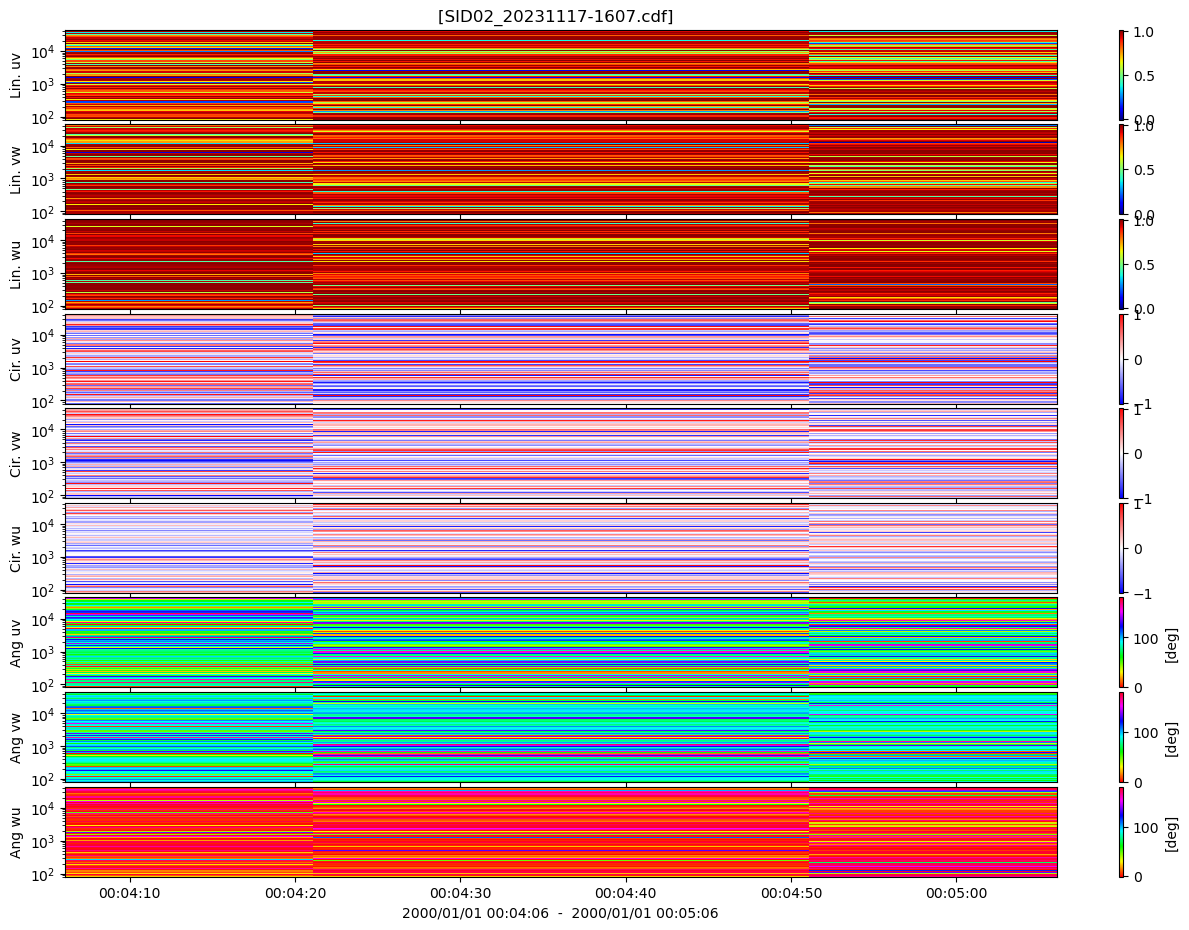

In [27]:
p_min = p_min1;  p_max = p_max1
f_min = f_min0;  f_max = f_max0
if f_mode == 0:
    f_min = f_mode_min;  f_max = f_mode_max

fig2d = plt.figure(figsize=[16,11])
if time_mode == 1:
    ax1 = fig2d.add_subplot(10, 1, 1); ax2 = fig2d.add_subplot(10, 1, 2); ax3 = fig2d.add_subplot(10, 1, 3)
    ax4 = fig2d.add_subplot(10, 1, 4); ax5 = fig2d.add_subplot(10, 1, 5); ax6 = fig2d.add_subplot(10, 1, 6)
    ax7 = fig2d.add_subplot(10, 1, 7); ax8 = fig2d.add_subplot(10, 1, 8); ax9 = fig2d.add_subplot(10, 1, 9); ax10 = fig2d.add_subplot(10, 1, 10)
else:
    ax1 = fig2d.add_subplot(9, 1, 1);  ax2 = fig2d.add_subplot(9, 1, 2);  ax3 = fig2d.add_subplot(9, 1, 3)
    ax4 = fig2d.add_subplot(9, 1, 4);  ax5 = fig2d.add_subplot(9, 1, 5);  ax6 = fig2d.add_subplot(9, 1, 6)
    ax7 = fig2d.add_subplot(9, 1, 7);  ax8 = fig2d.add_subplot(9, 1, 8);  ax9 = fig2d.add_subplot(9, 1, 9)

ax1.set_ylim(f_min0, f_max0); ax2.set_ylim(f_min0, f_max0); ax3.set_ylim(f_min0, f_max0); ax4.set_ylim(f_min0, f_max0); ax5.set_ylim(f_min0, f_max0)
ax6.set_ylim(f_min0, f_max0); ax7.set_ylim(f_min0, f_max0); ax8.set_ylim(f_min0, f_max0); ax9.set_ylim(f_min0, f_max0)
if f_mode == 1:
    ax1.set_yscale('log');    ax2.set_yscale('log');        ax3.set_yscale('log');        ax4.set_yscale('log');        ax5.set_yscale('log')
    ax6.set_yscale('log');    ax7.set_yscale('log');        ax8.set_yscale('log');        ax9.set_yscale('log')
ax1.set_ylabel('Lin. uv');    ax2.set_ylabel('Lin. vw');    ax3.set_ylabel('Lin. wu');    ax4.set_ylabel('Cir. uv');    ax5.set_ylabel('Cir. vw');  
ax6.set_ylabel('Cir. wu');    ax7.set_ylabel('Ang uv');     ax8.set_ylabel('Ang vw');     ax9.set_ylabel('Ang wu')
ax1.set_title("[" + data_name + "]  ");     
if time_mode == 1:
    ax10.set_xlabel(str_date)
else:
    ax9.set_xlabel(str_date)

if time_mode == 1:
    p1 = ax1.pcolormesh(num_1d, freq_1d, E_DoLuv_2d, norm=colors.Normalize(vmin=-0.01, vmax=1.01), cmap='jet')
    p2 = ax2.pcolormesh(num_1d, freq_1d, E_DoLvw_2d, norm=colors.Normalize(vmin=-0.01, vmax=1.01), cmap='jet')
    p3 = ax3.pcolormesh(num_1d, freq_1d, E_DoLwu_2d, norm=colors.Normalize(vmin=-0.01, vmax=1.01), cmap='jet')
    p4 = ax4.pcolormesh(num_1d, freq_1d, E_DoCuv_2d, norm=colors.Normalize(vmin=-1.01, vmax=1.01), cmap='bwr')
    p5 = ax5.pcolormesh(num_1d, freq_1d, E_DoCvw_2d, norm=colors.Normalize(vmin=-1.01, vmax=1.01), cmap='bwr')
    p6 = ax6.pcolormesh(num_1d, freq_1d, E_DoCwu_2d, norm=colors.Normalize(vmin=-1.01, vmax=1.01), cmap='bwr')
    p7 = ax7.pcolormesh(num_1d, freq_1d, E_ANGuv_2d, norm=colors.Normalize(vmin=-1.00, vmax=181.), cmap='hsv')
    p8 = ax8.pcolormesh(num_1d, freq_1d, E_ANGvw_2d, norm=colors.Normalize(vmin=-1.00, vmax=181.), cmap='hsv')
    p9 = ax9.pcolormesh(num_1d, freq_1d, E_ANGwu_2d, norm=colors.Normalize(vmin=-1.00, vmax=181.), cmap='hsv')
    p10 = ax10.plot(np.ravel(data.epoch[:]), '.')
    pp9 = fig2d.colorbar(p9, ax=ax10, orientation="vertical"); pp9.set_label(spec.str)
else:
    p1 = ax1.pcolormesh(Epoch_1d, freq_1d, E_DoLuv_2d, norm=colors.Normalize(vmin=-0.01, vmax=1.01), cmap='jet')
    p2 = ax2.pcolormesh(Epoch_1d, freq_1d, E_DoLvw_2d, norm=colors.Normalize(vmin=-0.01, vmax=1.01), cmap='jet')
    p3 = ax3.pcolormesh(Epoch_1d, freq_1d, E_DoLwu_2d, norm=colors.Normalize(vmin=-0.01, vmax=1.01), cmap='jet')
    p4 = ax4.pcolormesh(Epoch_1d, freq_1d, E_DoCuv_2d, norm=colors.Normalize(vmin=-1.01, vmax=1.01), cmap='bwr')
    p5 = ax5.pcolormesh(Epoch_1d, freq_1d, E_DoCvw_2d, norm=colors.Normalize(vmin=-1.01, vmax=1.01), cmap='bwr')
    p6 = ax6.pcolormesh(Epoch_1d, freq_1d, E_DoCwu_2d, norm=colors.Normalize(vmin=-1.01, vmax=1.01), cmap='bwr')
    p7 = ax7.pcolormesh(Epoch_1d, freq_1d, E_ANGuv_2d, norm=colors.Normalize(vmin=-1.00, vmax=181.), cmap='hsv')
    p8 = ax8.pcolormesh(Epoch_1d, freq_1d, E_ANGvw_2d, norm=colors.Normalize(vmin=-1.00, vmax=181.), cmap='hsv')
    p9 = ax9.pcolormesh(Epoch_1d, freq_1d, E_ANGwu_2d, norm=colors.Normalize(vmin=-1.00, vmax=181.), cmap='hsv')
pp1 = fig2d.colorbar(p1, ax=ax1, orientation="vertical"); pp2 = fig2d.colorbar(p2, ax=ax2, orientation="vertical")
pp3 = fig2d.colorbar(p3, ax=ax3, orientation="vertical"); pp4 = fig2d.colorbar(p4, ax=ax4, orientation="vertical")
pp5 = fig2d.colorbar(p5, ax=ax5, orientation="vertical"); pp6 = fig2d.colorbar(p6, ax=ax6, orientation="vertical")
pp7 = fig2d.colorbar(p7, ax=ax7, orientation="vertical"); pp8 = fig2d.colorbar(p8, ax=ax8, orientation="vertical")
pp9 = fig2d.colorbar(p9, ax=ax9, orientation="vertical"); pp7.set_label("[deg]"); pp8.set_label("[deg]"); pp9.set_label("[deg]")

if time_mode == 1:
    xlim=[num_1d[0],   num_1d[-1]];   ax10.set_xlim(xlim)
else:
    xlim=[Epoch_1d[0], Epoch_1d[-1]]
    # E_min = '2024-01-26 08:40:00';  t_min = datetime.datetime.strptime(E_min, "%Y-%m-%d %H:%M:%S");  
    # E_max = '2024-01-26 09:40:00';  t_max = datetime.datetime.strptime(E_max, "%Y-%m-%d %H:%M:%S");  
    # xlim=[t_min, t_max];        
ax1.set_xlim(xlim); ax2.set_xlim(xlim); ax3.set_xlim(xlim); ax4.set_xlim(xlim); ax5.set_xlim(xlim)
ax6.set_xlim(xlim); ax7.set_xlim(xlim); ax8.set_xlim(xlim); ax9.set_xlim(xlim)

plt.subplots_adjust(hspace=.05)
plt.show()
if dump_mode == 1:
    png_fname = work_dir+data_name+'_AngT.png'
    if f_mode == 1:
        png_fname = work_dir+data_name+'_AngT-log.png'
    fig2d.savefig(png_fname)

# Mask for SID3

In [28]:
n_mask = 19392
mask_list = np.zeros(n_mask * 3);  mask_list = mask_list.reshape(n_mask, 3)
mask_dir  = './lib/';  mask_name = 'hf_sid3_mask.csv';  mask_file = mask_dir + mask_name
with open(mask_file, 'r') as f:
    reader = csv.reader(f);  i = 0
    for row in reader:
        mask_list[i, 0] = row[1];  mask_list[i, 1] = row[2];  mask_list[i, 2] = row[3];   i = i+1
print("mask read: ", mask_list.shape, mask_file)

mask read:  (19392, 3) ./lib/hf_sid3_mask.csv


In [29]:
spec_msk = copy.deepcopy(spec)
for i in range(freq_1d.shape[0]):
    num_mask = np.int16((freq_1d[i] - 80) // 2.3125)
    if (num_mask >= 0 and num_mask < n_mask):
        if mask_list[num_mask,2] > 0:
            spec_msk.EE[:,i-1] = 0
            spec_msk.EE[:,i]   = 0
            if i<freq_1d.shape[0]-1:
                spec_msk.EE[:,i+1] = 0
# delete
mask_index0   = np.where (spec_msk.EE[0] == 0)
freq_1d_msk   = np.delete(freq_1d,       mask_index0, 0)
spec_msk.EuEu = np.delete(spec_msk.EuEu, mask_index0, 1)
spec_msk.EvEv = np.delete(spec_msk.EvEv, mask_index0, 1)
spec_msk.EwEw = np.delete(spec_msk.EwEw, mask_index0, 1)
EuEu_msk = np.nanmedian(spec_msk.EuEu, axis=0); EvEv_msk = np.nanmedian(spec_msk.EvEv, axis=0); EwEw_msk = np.nanmedian(spec_msk.EwEw, axis=0)
EuEu_msk_2d = spec_msk.EuEu.transpose();  EvEv_msk_2d = spec_msk.EvEv.transpose();  EwEw_msk_2d = spec_msk.EwEw.transpose() 
spec_msk.EE = spec_msk.EuEu + spec_msk.EvEv + spec_msk.EwEw;  EE_msk = EuEu_msk + EvEv_msk + EwEw_msk;  EE_msk_2d   = spec_msk.EE.transpose()

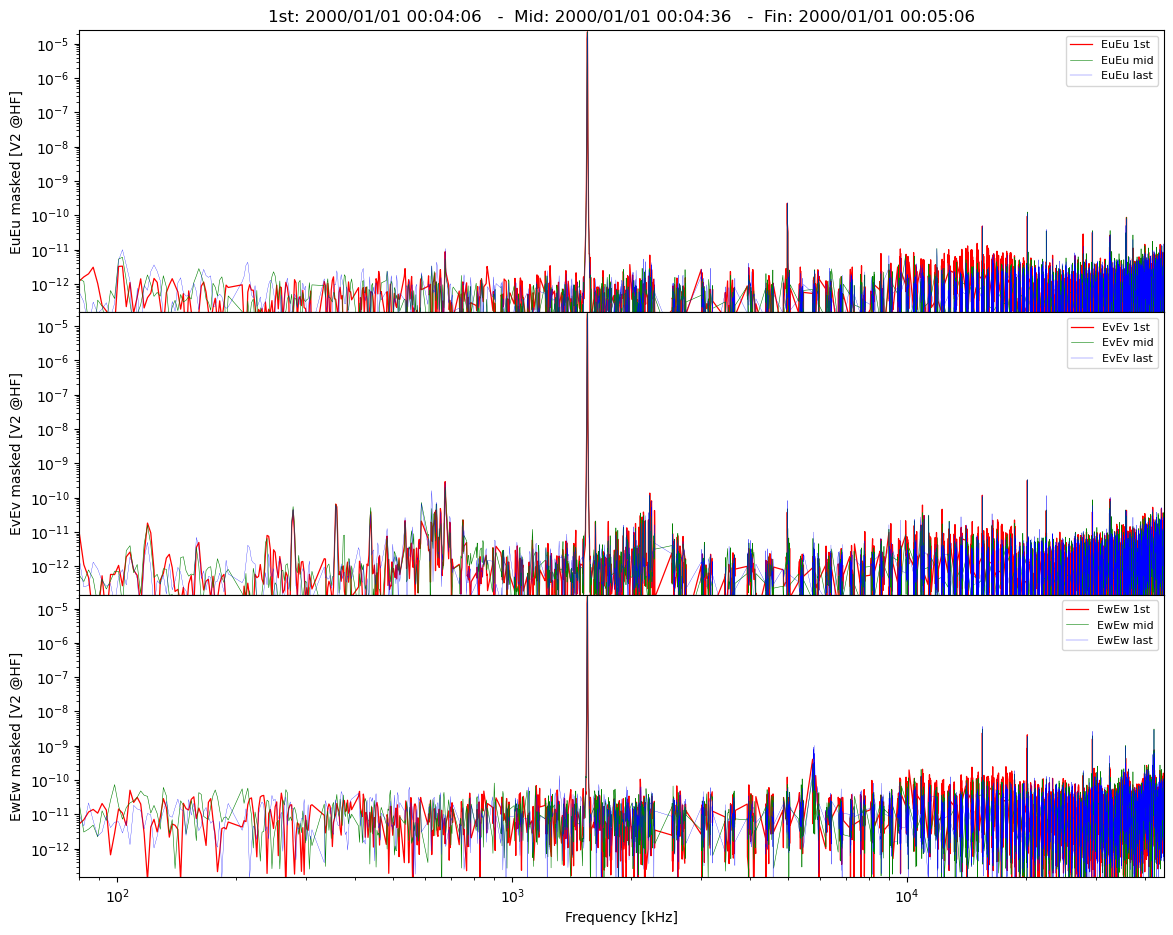

In [30]:
n_sweep1 = n_time1//4;  n_sweep2 = n_time1//2;  n_sweep3 = n_time1-1
p_min = p_min1;  p_max = p_max1
if cal_mode == 1:
    p_max = p_max1+2    
f_min = f_min0;  f_max = f_max0
if f_mode == 0:
    f_min = f_mode_min;  f_max = f_mode_max;  print(data.frequency[0][0][0], data.frequency[0][8][0])

fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(3, 1, 1);  ax2 = fig.add_subplot(3, 1, 2);  ax3 = fig.add_subplot(3, 1, 3)
ax1.plot(freq_1d_msk, spec_msk.EuEu[n_sweep1], '-r', linewidth=.9, label='EuEu 1st')
ax1.plot(freq_1d_msk, spec_msk.EuEu[n_sweep2], '-g', linewidth=.4, label='EuEu mid')
ax1.plot(freq_1d_msk, spec_msk.EuEu[n_sweep3], '-b', linewidth=.2, label='EuEu last')
ax2.plot(freq_1d_msk, spec_msk.EvEv[n_sweep1], '-r', linewidth=.9, label='EvEv 1st')
ax2.plot(freq_1d_msk, spec_msk.EvEv[n_sweep2], '-g', linewidth=.4, label='EvEv mid')
ax2.plot(freq_1d_msk, spec_msk.EvEv[n_sweep3], '-b', linewidth=.2, label='EvEv last')
ax3.plot(freq_1d_msk, spec_msk.EwEw[n_sweep1], '-r', linewidth=.9, label='EwEw 1st')
ax3.plot(freq_1d_msk, spec_msk.EwEw[n_sweep2], '-g', linewidth=.4, label='EwEw mid')
ax3.plot(freq_1d_msk, spec_msk.EwEw[n_sweep3], '-b', linewidth=.2, label='EwEw last')

ax1.set_yscale('log');      ax2.set_yscale('log');  ax3.set_yscale('log')
if f_mode == 1:
    ax1.set_xscale('log');  ax2.set_xscale('log');  ax3.set_xscale('log')
ax1.set_ylabel('EuEu masked '+spec.str);     ax2.set_ylabel('EvEv masked '+spec.str); ax3.set_ylabel('EwEw masked '+spec.str);  ax3.set_xlabel('Frequency [kHz]')
date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime('1st: %Y/%m/%d %R:%S ')
date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime('Mid: %Y/%m/%d %R:%S ')
date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime('Fin: %Y/%m/%d %R:%S')
title_date = date1 + "  -  " + date2 + "  -  " + date3;   ax1.set_title(title_date)
ax1.legend(loc='upper right', fontsize=8);  ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8)

# range: X-axis
xlim=[f_min, f_max]
ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim)
# range: Y-axis
# p_max = np.log10(np.nanmax([np.nanmax(spec_msk.EuEu), np.nanmax(spec_msk.EvEv), np.nanmax(spec_msk.EwEw)]))*10)/10
ylim=[10**(p_min), 10**(p_max)]
ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim)

# Plot
fig.subplots_adjust(hspace=0)
fig.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'-msk_spec.png'
    if f_mode == 1:
        png_fname = work_dir+data_name+'-msk_spec-log.png'
    fig.savefig(png_fname)

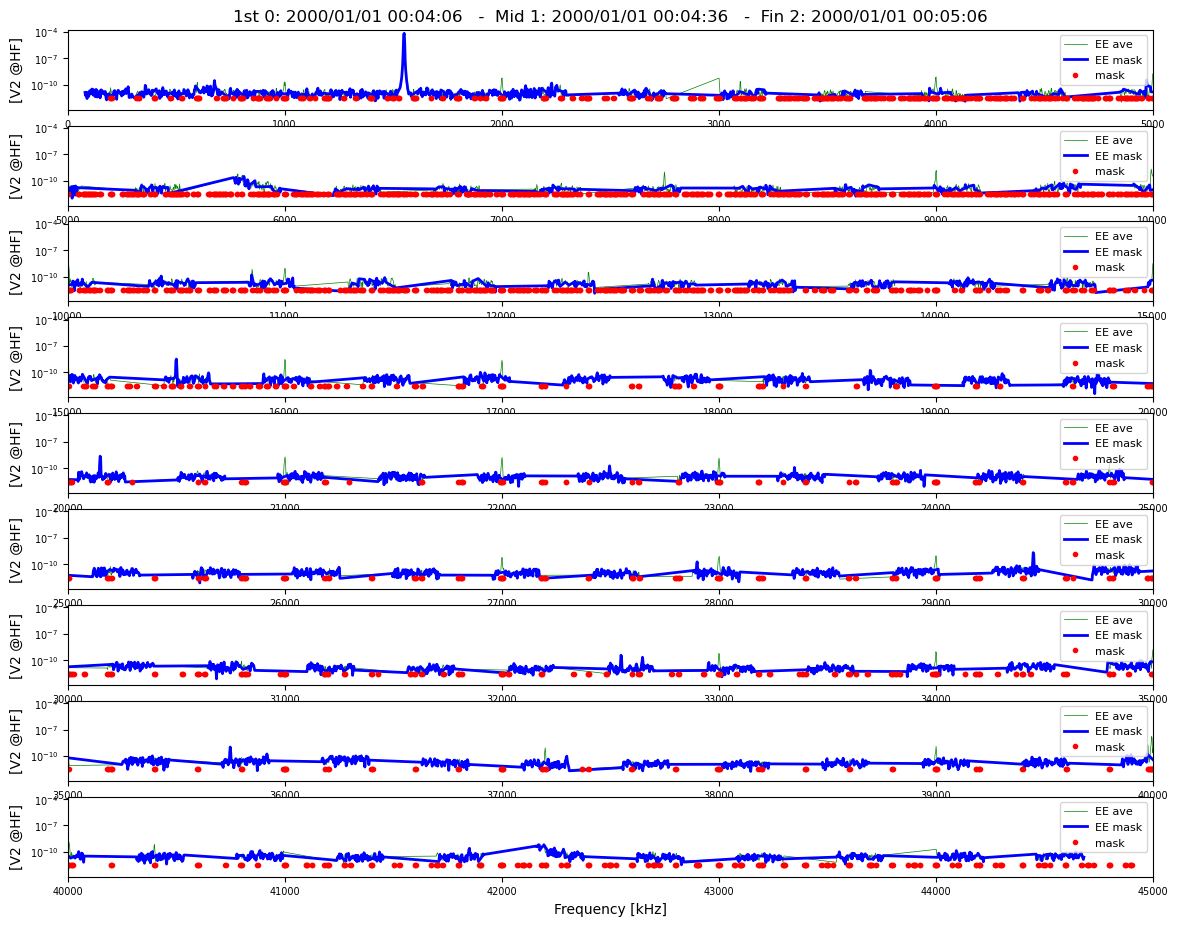

In [31]:
n_sweep1 = n_time1//4;  n_sweep2 = n_time1//2;  n_sweep3 = 3*n_time1//4
p_min = p_min1;  p_max = p_max1
if cal_mode == 1:
    p_max = p_max1+2    
f_min = 0;       f_max = 5000

fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(9, 1, 1);  ax2 = fig.add_subplot(9, 1, 2);  ax3 = fig.add_subplot(9, 1, 3);  ax4 = fig.add_subplot(9, 1, 4)
ax5 = fig.add_subplot(9, 1, 5);  ax6 = fig.add_subplot(9, 1, 6);  ax7 = fig.add_subplot(9, 1, 7);  ax8 = fig.add_subplot(9, 1, 8);  ax9 = fig.add_subplot(9, 1, 9)

ax1.plot(freq_1d, EE_med, '-g', linewidth=.5, label='EE ave'); ax1.plot(freq_1d_msk, EE_msk, '-b', linewidth=2, label='EE mask')
ax2.plot(freq_1d, EE_med, '-g', linewidth=.5, label='EE ave'); ax2.plot(freq_1d_msk, EE_msk, '-b', linewidth=2, label='EE mask')
ax3.plot(freq_1d, EE_med, '-g', linewidth=.5, label='EE ave'); ax3.plot(freq_1d_msk, EE_msk, '-b', linewidth=2, label='EE mask')
ax4.plot(freq_1d, EE_med, '-g', linewidth=.5, label='EE ave'); ax4.plot(freq_1d_msk, EE_msk, '-b', linewidth=2, label='EE mask')
ax5.plot(freq_1d, EE_med, '-g', linewidth=.5, label='EE ave'); ax5.plot(freq_1d_msk, EE_msk, '-b', linewidth=2, label='EE mask')
ax6.plot(freq_1d, EE_med, '-g', linewidth=.5, label='EE ave'); ax6.plot(freq_1d_msk, EE_msk, '-b', linewidth=2, label='EE mask')
ax7.plot(freq_1d, EE_med, '-g', linewidth=.5, label='EE ave'); ax7.plot(freq_1d_msk, EE_msk, '-b', linewidth=2, label='EE mask')
ax8.plot(freq_1d, EE_med, '-g', linewidth=.5, label='EE ave'); ax8.plot(freq_1d_msk, EE_msk, '-b', linewidth=2, label='EE mask')
ax9.plot(freq_1d, EE_med, '-g', linewidth=.5, label='EE ave'); ax9.plot(freq_1d_msk, EE_msk, '-b', linewidth=2, label='EE mask')
ax1.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.r', label='mask'); ax2.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.r', label='mask')
ax3.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.r', label='mask'); ax4.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.r', label='mask')
ax5.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.r', label='mask'); ax6.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.r', label='mask')
ax7.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.r', label='mask'); ax8.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.r', label='mask')
ax9.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.r', label='mask')

ax1.set_yscale('log');  ax2.set_yscale('log');  ax3.set_yscale('log');  ax4.set_yscale('log');  ax5.set_yscale('log')
ax6.set_yscale('log');  ax7.set_yscale('log');  ax8.set_yscale('log');  ax9.set_yscale('log')
ax1.set_ylabel(spec.str); ax2.set_ylabel(spec.str); ax3.set_ylabel(spec.str); ax4.set_ylabel(spec.str); ax5.set_ylabel(spec.str)
ax6.set_ylabel(spec.str); ax7.set_ylabel(spec.str); ax8.set_ylabel(spec.str); ax9.set_ylabel(spec.str)
ax9.set_xlabel('Frequency [kHz]')
date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime(f'1st {n_sweep1}: %Y/%m/%d %R:%S ')
date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime(f'Mid {n_sweep2}: %Y/%m/%d %R:%S ')
date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime(f'Fin {n_sweep3}: %Y/%m/%d %R:%S')
title_date = date1 + "  -  " + date2 + "  -  " + date3;  ax1.set_title(title_date)
ax1.legend(loc='upper right', fontsize=8);  ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8)
ax4.legend(loc='upper right', fontsize=8);  ax5.legend(loc='upper right', fontsize=8);  ax6.legend(loc='upper right', fontsize=8)
ax7.legend(loc='upper right', fontsize=8);  ax8.legend(loc='upper right', fontsize=8);  ax9.legend(loc='upper right', fontsize=8)

xlim=[f_min,       f_max];        ax1.set_xlim(xlim); xlim=[f_min+5000,  f_max+5000];   ax2.set_xlim(xlim)  
xlim=[f_min+10000, f_max+10000];  ax3.set_xlim(xlim); xlim=[f_min+15000, f_max+15000];  ax4.set_xlim(xlim)
xlim=[f_min+20000, f_max+20000];  ax5.set_xlim(xlim); xlim=[f_min+25000, f_max+25000];  ax6.set_xlim(xlim)
xlim=[f_min+30000, f_max+30000];  ax7.set_xlim(xlim); xlim=[f_min+35000, f_max+35000];  ax8.set_xlim(xlim)
xlim=[f_min+40000, f_max+40000];  ax9.set_xlim(xlim)
ax1.tick_params(labelsize=7); ax2.tick_params(labelsize=7); ax3.tick_params(labelsize=7); ax4.tick_params(labelsize=7); ax5.tick_params(labelsize=7)
ax6.tick_params(labelsize=7); ax7.tick_params(labelsize=7); ax8.tick_params(labelsize=7); ax9.tick_params(labelsize=7)

# ylim=[10**p_min, 10**p_max]
# ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim); ax5.set_ylim(ylim); ax6.set_ylim(ylim);  
# ax7.set_ylim(ylim); ax8.set_ylim(ylim);  ax9.set_ylim(ylim)

fig.subplots_adjust(hspace=0.2)
fig.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'-msk_spec-fine.png'
    fig.savefig(png_fname)

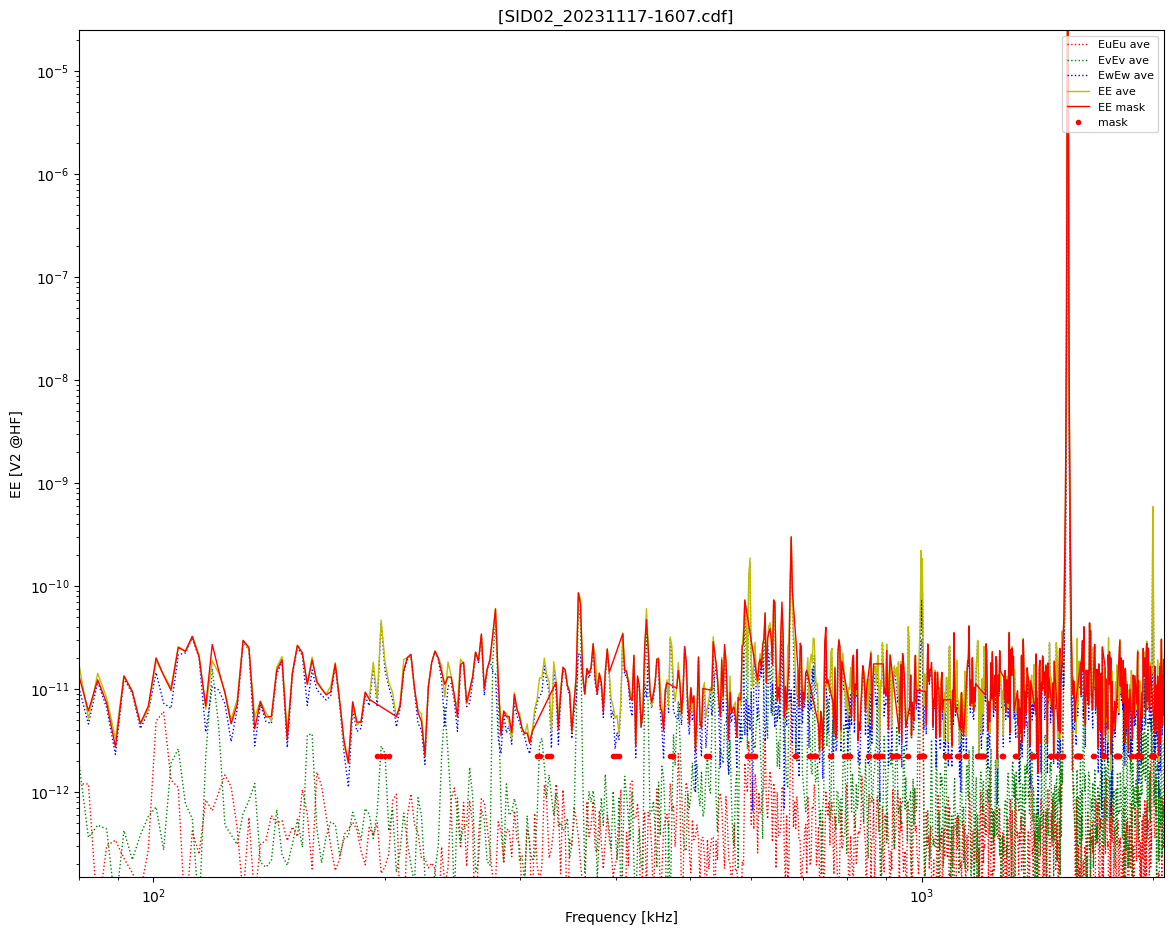

In [32]:
p_min = p_min1;   p_max = p_max1
if cal_mode == 1:
    p_max = p_max1+2    
f_min = f_min0;   f_max = f_max0
f_min = 80;       f_max = 2068
if f_mode == 0:
    f_min = f_mode_min;  f_max = f_mode_max;  

fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(freq_1d,     EuEu_med, ':r', linewidth=1, label='EuEu ave')
ax1.plot(freq_1d,     EvEv_med, ':g', linewidth=1, label='EvEv ave')
ax1.plot(freq_1d,     EwEw_med, ':b', linewidth=1, label='EwEw ave')
ax1.plot(freq_1d,     EE_med,   '-y', linewidth=1,  label='EE ave')
ax1.plot(freq_1d_msk, EE_msk,   '-r', linewidth=1,  label='EE mask')
ax1.plot(mask_list[:,0], mask_list[:,2]*15*10**p_min, '.r', label='mask')
ax1.set_yscale('log')
if f_mode == 1:
    ax1.set_xscale('log')
ax1.set_ylabel('EE '+spec.str);  ax1.set_xlabel('Frequency [kHz]');  ax1.legend(loc='upper right', fontsize=8)
ax1.set_title("[" + data_name + "]  ");     

xlim=[f_min, f_max];         ax1.set_xlim(xlim); 
ylim=[10**p_min, 10**p_max]; ax1.set_ylim(ylim)

fig.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'-msk_spec2.png'
    fig.savefig(png_fname)

In [33]:
peak_E = np.ravel(EuEu_med[0:100]); peak_f = np.argmax(peak_E); print("Peak EuEu:", freq_1d[peak_f], '{:.2e}'.format(peak_E[peak_f]), '{:.2e}'.format(peak_E[peak_f]**.5), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])**.5))
peak_E = np.ravel(EvEv_med[0:100]); peak_f = np.argmax(peak_E); print("Peak EvEv:", freq_1d[peak_f], '{:.2e}'.format(peak_E[peak_f]), '{:.2e}'.format(peak_E[peak_f]**.5), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])**.5))
peak_E = np.ravel(EwEw_med[0:100]); peak_f = np.argmax(peak_E); print("Peak EwEw:", freq_1d[peak_f], '{:.2e}'.format(peak_E[peak_f]), '{:.2e}'.format(peak_E[peak_f]**.5), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])), '{:.2e}'.format( (peak_E[peak_f-2]+peak_E[peak_f-1]+peak_E[peak_f]+peak_E[peak_f+1]+peak_E[peak_f+2])**.5))
print(spec.freq_w[0])

Peak EuEu: 103.125 6.01e-12 2.45e-06 1.36e-11 3.68e-06
Peak EvEv: 278.875 4.57e-11 6.76e-06 7.36e-11 8.58e-06
Peak EwEw: 197.9375 4.44e-11 6.67e-06 9.34e-11 9.67e-06
[2.3125 2.3125 2.3125 ... 2.3125 2.3125 2.3125]


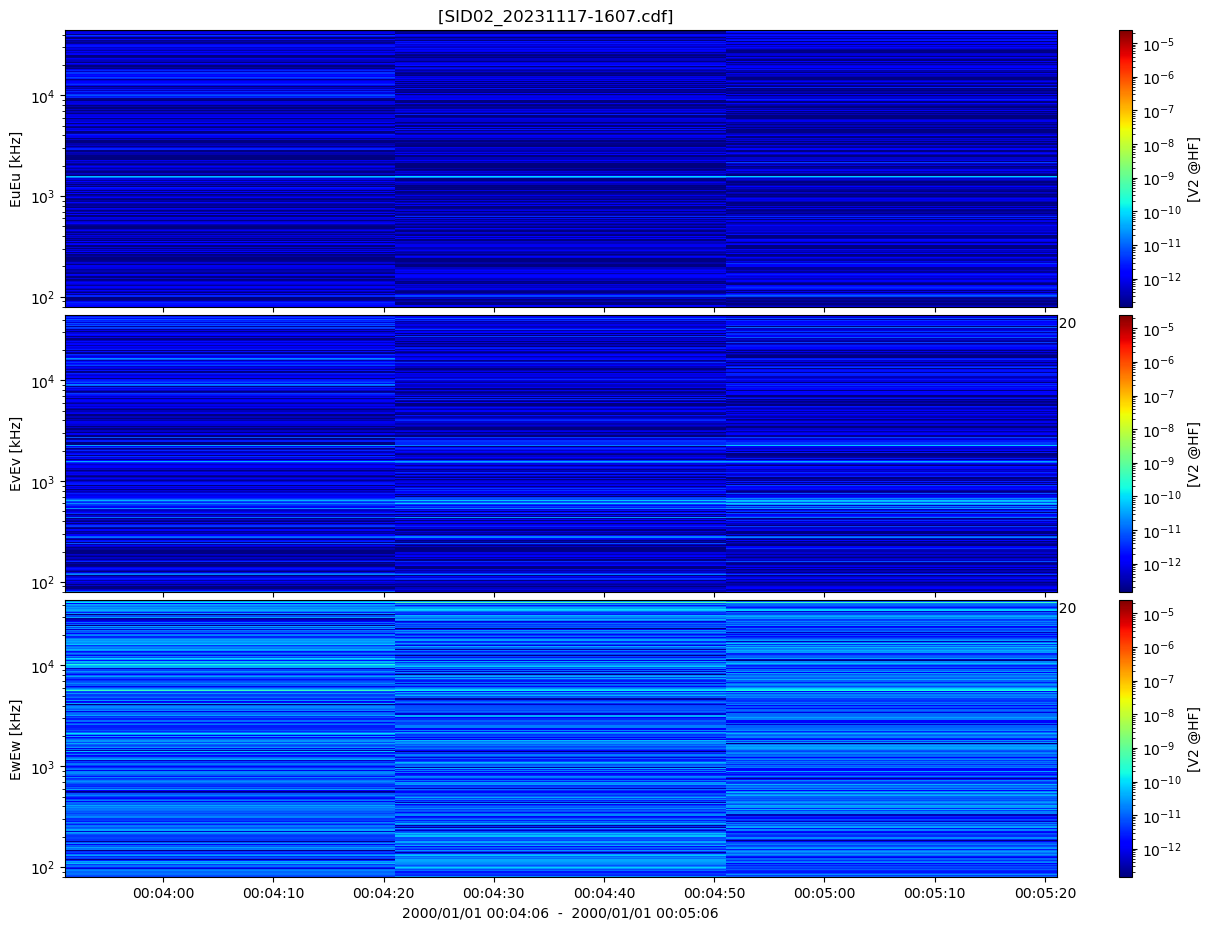

In [34]:
p_min = p_min1;  p_max = p_max1
f_min = f_min0;  f_max = f_max0
if f_mode == 0:
    f_min = f_mode_min;  f_max = f_mode_max;  print(data.frequency[0][0][0], data.frequency[0][8][0])

fig2d = plt.figure(figsize=[16,11])
if time_mode == 1:
    ax1 = fig2d.add_subplot(4, 1, 1); ax2 = fig2d.add_subplot(4, 1, 2); ax3 = fig2d.add_subplot(4, 1, 3); ax4.set_xlabel(str_date); ax4 = fig2d.add_subplot(4, 1, 4)
else:
    ax1 = fig2d.add_subplot(3, 1, 1); ax2 = fig2d.add_subplot(3, 1, 2); ax3 = fig2d.add_subplot(3, 1, 3);                           ax3.set_xlabel(str_date)

ax1.set_ylabel('EuEu [kHz]');     ax2.set_ylabel('EvEv [kHz]');     ax3.set_ylabel('EwEw [kHz]')
ax1.set_ylim(f_min, f_max); ax2.set_ylim(f_min, f_max); ax3.set_ylim(f_min, f_max)
if f_mode == 1:
    ax1.set_yscale('log');        ax2.set_yscale('log');        ax3.set_yscale('log')

if time_mode == 1:
    p1 = ax1.pcolormesh(num_1d, freq_1d_msk, EuEu_msk_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p2 = ax2.pcolormesh(num_1d, freq_1d_msk, EvEv_msk_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p3 = ax3.pcolormesh(num_1d, freq_1d_msk, EwEw_msk_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p4 = ax4.plot(np.ravel(spec.epoch[:]), '.')
    pp3 = fig2d.colorbar(p3, ax=ax4, orientation="vertical"); pp3.set_label(spec.str)
else:
    p1 = ax1.pcolormesh(Epoch_1d, freq_1d_msk, EuEu_msk_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p2 = ax2.pcolormesh(Epoch_1d, freq_1d_msk, EvEv_msk_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    p3 = ax3.pcolormesh(Epoch_1d, freq_1d_msk, EwEw_msk_2d, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
pp1 = fig2d.colorbar(p1, ax=ax1, orientation="vertical"); pp1.set_label(spec.str)
pp2 = fig2d.colorbar(p2, ax=ax2, orientation="vertical"); pp2.set_label(spec.str)
pp3 = fig2d.colorbar(p3, ax=ax3, orientation="vertical"); pp3.set_label(spec.str)
ax1.set_title("[" + data_name + "]  ");     

if time_mode == 1:
    xlim=[num_1d[0], num_1d[-1]]; ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim)

plt.subplots_adjust(hspace=.03)
plt.show
if dump_mode == 1:
    png_fname = work_dir+data_name+'-msk_FT.png'
    if f_mode == 1:
        png_fname = work_dir+data_name+'-msk_FT-log.png'
    fig2d.savefig(png_fname)

# Other SID emulations

In [35]:
sid3_sim = 0
sid4_sim = 0
sid5_sim = 0

## SID-3 emulation

In [36]:
if sid3_sim > 0:
    asw_ver = 2
    freq_1d_sid, f_step_sid, f_width_sid = juice_cdf._frequency_sid3(asw_ver)
    n_freq1_sid = len(freq_1d_sid)
    tbl_freq_to_sid     = juice_cdf._frequency_sid2_to_data(freq_1d_sid, f_step_sid, freq_1d)
    tbl_freq_to_sid_msk = juice_cdf._frequency_sid2_to_data(freq_1d_sid, f_step_sid, freq_1d_msk)
    spec_sid_EE      = np.zeros((n_time0, n_freq1_sid));  spec_sid_EE_msk      = np.zeros((n_time0, n_freq1_sid))
    spec_sid_EE_med  = np.zeros((n_time0, n_freq1_sid));  spec_sid_EE_msk_med  = np.zeros((n_time0, n_freq1_sid))
    spec_sid_EE_mean = np.zeros((n_time0, n_freq1_sid));  spec_sid_EE_msk_mean = np.zeros((n_time0, n_freq1_sid))
    spec_sid_count   = np.zeros((n_time0, n_freq1_sid));  spec_sid_count_msk   = np.zeros((n_time0, n_freq1_sid))
    for i in range(n_time0):
        for j in range(n_freq1_sid):
            j0 = tbl_freq_to_sid[j][0];                                  j0_msk = tbl_freq_to_sid_msk[j][0]
            j1 = tbl_freq_to_sid[j][1];                                  j1_msk = tbl_freq_to_sid_msk[j][1]
            j2 = tbl_freq_to_sid[j][2];                                  j2_msk = tbl_freq_to_sid_msk[j][2]
            spec_sid_EE[i][j]      = np.nansum   (spec.EE[i][j0:j1+1]);  spec_sid_EE_msk[i][j]      = np.nansum   (spec_msk.EE[i][j0_msk:j1_msk+1])
            spec_sid_EE_med[i][j]  = np.nanmedian(spec.EE[i][j0:j1+1]);  spec_sid_EE_msk_med[i][j]  = np.nanmedian(spec_msk.EE[i][j0_msk:j1_msk+1])
            spec_sid_EE_mean[i][j] = np.nanmean  (spec.EE[i][j0:j1+1]);  spec_sid_EE_msk_mean[i][j] = np.nanmean  (spec_msk.EE[i][j0_msk:j1_msk+1])
            spec_sid_count[i][j]   = j1-j0+1;                            spec_sid_count_msk[i][j]   = j1_msk-j0_msk*1
    EE_sid_2d      = spec_sid_EE.transpose();       EE_sid_2d_msk      = spec_sid_EE_msk.transpose()
    EE_sid_2d_med  = spec_sid_EE_med.transpose();   EE_sid_2d_msk_med  = spec_sid_EE_msk_med.transpose()
    EE_sid_2d_mean = spec_sid_EE_mean.transpose();  EE_sid_2d_msk_mean = spec_sid_EE_msk_mean.transpose()

In [37]:
if sid3_sim > 0:
    n_sweep1 = n_time0//2
    p_min = p_min1;  p_max = p_max1
    if cal_mode == 1:
        p_max = p_max1+2    
    f_min = f_min0;  f_max = f_max0
    if f_mode == 0:
        f_min = f_mode_min;  f_max = f_mode_max;  print(data.frequency[0][0][0], data.frequency[0][8][0])

    fig = plt.figure(figsize=(14, 11))
    ax1 = fig.add_subplot(4, 1, 1);  ax2 = fig.add_subplot(4, 1, 2);  ax3 = fig.add_subplot(4, 1, 3);  ax4 = fig.add_subplot(4, 1, 4)

    ax1.plot(freq_1d,     spec.EE[n_sweep1],              ':r', linewidth=.9, label='EE(SID-2)')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep1],          '-r', linewidth=.9, label='EE(SID-3)')
    ax1.plot(freq_1d_sid, spec_sid_EE_mean[n_sweep1],     '-g', linewidth=.9, label='EE_mean(SID-3)')
    ax1.plot(freq_1d_sid, spec_sid_EE_med[n_sweep1],      '-b', linewidth=.9, label='EE_med(SID-3)')
    #
    ax2.plot(freq_1d_msk, spec_msk.EE[n_sweep1],          ':r', linewidth=.9, label='EE_msk(SID-2)')
    ax2.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep1],      '-r', linewidth=.9, label='EE_msk(SID-3)')
    ax2.plot(freq_1d_sid, spec_sid_EE_msk_mean[n_sweep1], '-g', linewidth=.9, label='EE_msk_mean(SID-3)')
    ax2.plot(freq_1d_sid, spec_sid_EE_msk_med[n_sweep1],  '-b', linewidth=.9, label='EE_msk_med(SID-3)')
    #
    ax3.plot(freq_1d,     spec.EE[n_sweep1],              ':r', linewidth=.9, label='EE(SID-2)')
    ax3.plot(freq_1d_msk, spec_msk.EE[n_sweep1],          '-b', linewidth=.9, label='EE_msk(SID-2)')
    #
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep1],          ':r', linewidth=.9, label='EE(SID-3)')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep1],      '-r', linewidth=.9, label='EE_msk(SID-3)')
    ax4.plot(freq_1d_sid, spec_sid_EE_mean[n_sweep1],     ':g', linewidth=.9, label='EE_mean(SID-3)')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk_mean[n_sweep1],'-g', linewidth=.9, label='EE_msk_mean(SID-3)')
    ax4.plot(freq_1d_sid, spec_sid_EE_med[n_sweep1],      ':b', linewidth=.9, label='EE_med(SID-3)')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk_med[n_sweep1],  '-b', linewidth=.9, label='EE_msk_med(SID-3)')
    ax1.set_yscale('log'); ax2.set_yscale('log');  ax3.set_yscale('log');  ax4.set_yscale('log')
    if f_mode == 1:
        ax1.set_xscale('log');  ax2.set_xscale('log');  ax3.set_xscale('log');  ax4.set_xscale('log')

    ax1.set_ylabel('EE '+spec.str);       ax2.set_ylabel('EE-msk '+spec.str)
    ax3.set_ylabel('EE:SID-2 '+spec.str); ax4.set_ylabel('EE:SID-3 emu '+spec.str); ax4.set_xlabel('Frequency [kHz]')
    date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime('1st: %Y/%m/%d %R:%S   ')
    date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime('Mid: %Y/%m/%d %R:%S   ')
    date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime('Fin: %Y/%m/%d %R:%S')
    title_date = date1 + "  -  " + date2 + "  -  " + date3;  ax1.set_title(title_date)
    ax1.legend(loc='upper right', fontsize=8); ax2.legend(loc='upper right', fontsize=8); ax3.legend(loc='upper right', fontsize=8); ax4.legend(loc='upper right', fontsize=8)

    xlim=[f_min, f_max];             ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim)
    ylim=[10**(p_min), 10**(p_max)]; ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim)

    fig.subplots_adjust(hspace=0)
    fig.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'-sid3emu_spec.png'
        if f_mode == 1:
            png_fname = work_dir+data_name+'-sid3emu_spec-log.png'
        fig.savefig(png_fname)

In [38]:
if sid3_sim > 0:
    n_sweep1 = n_time0//4;  n_sweep2 = n_time0//2;  n_sweep3 = n_time0-1
    p_min = p_min1;  p_max = p_max1
    f_min = f_min0;  f_max = f_max0
    if f_mode == 0:
        f_min = f_mode_min;  f_max = f_mode_max

    fig = plt.figure(figsize=(14, 11))
    ax1 = fig.add_subplot(4, 1, 1);  ax2 = fig.add_subplot(4, 1, 2);  ax3 = fig.add_subplot(4, 1, 3);  ax4 = fig.add_subplot(4, 1, 4)

    ax1.plot(freq_1d,     spec.EE[n_sweep1],         ':r', linewidth=.9, label='EE(SID-2) 1st')
    ax1.plot(freq_1d,     spec.EE[n_sweep2],         ':g', linewidth=.5, label='EE(SID-2) mid')
    ax1.plot(freq_1d,     spec.EE[n_sweep3],         ':b', linewidth=.5, label='EE(SID-2) last')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep1],     '-r', linewidth=.9, label='EE(SID-3) 1st')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep2],     '-g', linewidth=.5, label='EE(SID-3) mid')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep3],     '-b', linewidth=.5, label='EE(SID-3) last')
    #
    ax2.plot(freq_1d_msk, spec_msk.EE[n_sweep1],     ':r', linewidth=.9, label='EE_msk(SID-2) 1st')
    ax2.plot(freq_1d_msk, spec_msk.EE[n_sweep2],     ':g', linewidth=.5, label='EE_msk(SID-2) mid')
    ax2.plot(freq_1d_msk, spec_msk.EE[n_sweep3],     ':b', linewidth=.5, label='EE_msk(SID-2) last')
    ax2.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep1], '-r', linewidth=.9, label='EE_msk(SID-3) 1st')
    ax2.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep2], '-g', linewidth=.5, label='EE_msk(SID-3) mid')
    ax2.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep3], '-b', linewidth=.5, label='EE_msk(SID-3) last')
    #
    ax3.plot(freq_1d,     spec.EE[n_sweep1],         ':r', linewidth=.9, label='EE(SID-2) 1st')
    ax3.plot(freq_1d,     spec.EE[n_sweep2],         ':g', linewidth=.5, label='EE(SID-2) mid')
    ax3.plot(freq_1d,     spec.EE[n_sweep3],         ':b', linewidth=.3, label='EE(SID-2) last')
    ax3.plot(freq_1d_msk, spec_msk.EE[n_sweep1],     '-r', linewidth=.9, label='EE_msk(SID-2) 1st')
    ax3.plot(freq_1d_msk, spec_msk.EE[n_sweep2],     '-g', linewidth=.5, label='EE_msk(SID-2) mid')
    ax3.plot(freq_1d_msk, spec_msk.EE[n_sweep3],     '-b', linewidth=.5, label='EE_msk(SID-2) last')
    #
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep1],     ':r', linewidth=.9, label='EE(SID-3) 1st')
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep2],     ':g', linewidth=.5, label='EE(SID-3) mid')
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep3],     ':b', linewidth=.5, label='EE(SID-3) last')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep1], '-r', linewidth=.9, label='EE_msk(SID-3) 1st')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep2], '-g', linewidth=.5, label='EE_msk(SID-3) mid')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep3], '-b', linewidth=.5, label='EE_msk(SID-3) last')
    ax1.set_yscale('log'); ax2.set_yscale('log');  ax3.set_yscale('log');  ax4.set_yscale('log')
    if f_mode == 1:
        ax1.set_xscale('log');  ax2.set_xscale('log');  ax3.set_xscale('log');  ax4.set_xscale('log')

    # Label
    ax1.set_ylabel('EE '+spec.str);       ax2.set_ylabel('EE-msk '+spec.str)
    ax3.set_ylabel('EE:SID-2 '+spec.str); ax4.set_ylabel('EE:SID-3 emu '+spec.str); ax4.set_xlabel('Frequency [kHz]')
    #
    date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime('1st: %Y/%m/%d %R:%S   ')
    date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime('Mid: %Y/%m/%d %R:%S   ')
    date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime('Fin: %Y/%m/%d %R:%S')
    title_date = date1 + "  -  " + date2 + "  -  " + date3
    ax1.set_title(title_date)
    #
    ax1.legend(loc='upper right', fontsize=8);  
    ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8);   ax4.legend(loc='upper right', fontsize=8)

    xlim=[f_min, f_max];             ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim)
    ylim=[10**(p_min), 10**(p_max)]; ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim)

    fig.subplots_adjust(hspace=0)
    fig.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'-sid3emu_spec2.png'
        if f_mode == 1:
            png_fname = work_dir+data_name+'-sid3emu_spec2-log.png'
        fig.savefig(png_fname)

In [39]:
if sid3_sim > 0:
    n_sweep1 = n_time0//4;  n_sweep2 = n_time0//2;  n_sweep3 = n_time0-1
    p_min = p_min1;  p_max = p_max1
    if cal_mode == 1:
        p_max = p_max1+2    
    f_min = f_min0;  f_max = f_max0
    if f_mode == 0:
        f_min = f_mode_min;  f_max = f_mode_max

    fig = plt.figure(figsize=(14, 11))
    ax1 = fig.add_subplot(4, 1, 1);  ax2 = fig.add_subplot(4, 1, 2);  ax3 = fig.add_subplot(4, 1, 3);  ax4 = fig.add_subplot(4, 1, 4)

    ax1.plot(freq_1d,     spec.EE[n_sweep1],             ':r', linewidth=.9, label='EE(SID-2) 1st')
    ax1.plot(freq_1d,     spec.EE[n_sweep2],             ':g', linewidth=.5, label='EE(SID-2) mid')
    ax1.plot(freq_1d,     spec.EE[n_sweep3],             ':k', linewidth=.5, label='EE(SID-2) last')
    ax1.plot(freq_1d_sid, spec_sid_EE_med[n_sweep1],     '-r', linewidth=.9, label='EE(SID-3) med 1st')
    ax1.plot(freq_1d_sid, spec_sid_EE_med[n_sweep2],     '-g', linewidth=.5, label='EE(SID-3) med mid')
    ax1.plot(freq_1d_sid, spec_sid_EE_med[n_sweep3],     '-k', linewidth=.5, label='EE(SID-3) med last')
    #
    ax2.plot(freq_1d_msk, spec_msk.EE[n_sweep1],         ':r', linewidth=.9, label='EE_msk(SID-2) 1st')
    ax2.plot(freq_1d_msk, spec_msk.EE[n_sweep2],         ':g', linewidth=.5, label='EE_msk(SID-2) mid')
    ax2.plot(freq_1d_msk, spec_msk.EE[n_sweep3],         ':k', linewidth=.5, label='EE_msk(SID-2) last')
    ax2.plot(freq_1d_sid, spec_sid_EE_msk_med[n_sweep1], '-r', linewidth=.9, label='EE_msk(SID-3) med 1st')
    ax2.plot(freq_1d_sid, spec_sid_EE_msk_med[n_sweep2], '-g', linewidth=.5, label='EE_msk(SID-3) med mid')
    ax2.plot(freq_1d_sid, spec_sid_EE_msk_med[n_sweep3], '-k', linewidth=.5, label='EE_msk(SID-3) med last')
    #
    ax3.plot(freq_1d,     spec.EE[n_sweep1],             ':r', linewidth=.9, label='EE(SID-2) 1st')
    ax3.plot(freq_1d,     spec.EE[n_sweep2],             ':g', linewidth=.5, label='EE(SID-2) mid')
    ax3.plot(freq_1d,     spec.EE[n_sweep3],             ':k', linewidth=.3, label='EE(SID-2) last')
    ax3.plot(freq_1d_msk, spec_msk.EE[n_sweep1],         '-r', linewidth=.9, label='EE_msk(SID-2) 1st')
    ax3.plot(freq_1d_msk, spec_msk.EE[n_sweep2],         '-g', linewidth=.5, label='EE_msk(SID-2) mid')
    ax3.plot(freq_1d_msk, spec_msk.EE[n_sweep3],         '-k', linewidth=.5, label='EE_msk(SID-2) last')
    #
    ax4.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep1],     ':r', linewidth=.9, label='EE(SID-3) med 1st')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep2],     ':g', linewidth=.5, label='EE(SID-3) med mid')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk[n_sweep3],     ':k', linewidth=.5, label='EE(SID-3) med last')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk_med[n_sweep1], '-r', linewidth=.9, label='EE_msk(SID-3) med 1st')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk_med[n_sweep2], '-g', linewidth=.5, label='EE_msk(SID-3) med mid')
    ax4.plot(freq_1d_sid, spec_sid_EE_msk_med[n_sweep3], '-k', linewidth=.5, label='EE_msk(SID-3) med last')
    ax1.set_yscale('log'); ax2.set_yscale('log');  ax3.set_yscale('log');  ax4.set_yscale('log')
    if f_mode == 1:
        ax1.set_xscale('log');  ax2.set_xscale('log');  ax3.set_xscale('log');  ax4.set_xscale('log')

    ax1.set_ylabel('EE '+spec.str);       ax2.set_ylabel('EE-msk '+spec.str)
    ax3.set_ylabel('EE:SID-2 '+spec.str); ax4.set_ylabel('EE:SID-3 emu '+spec.str); ax4.set_xlabel('Frequency [kHz]')
    date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime('1st: %Y/%m/%d %R:%S   ')
    date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime('Mid: %Y/%m/%d %R:%S   ')
    date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime('Fin: %Y/%m/%d %R:%S')
    title_date = date1 + "  -  " + date2 + "  -  " + date3; ax1.set_title(title_date)
    ax1.legend(loc='upper right', fontsize=8); ax2.legend(loc='upper right', fontsize=8); ax3.legend(loc='upper right', fontsize=8); ax4.legend(loc='upper right', fontsize=8)

    xlim=[f_min, f_max];             ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim)
    ylim=[10**(p_min), 10**(p_max)]; ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim)

    # Plot
    fig.subplots_adjust(hspace=0)
    fig.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'-sid3emu_spec-med.png'
        if f_mode == 1:
            png_fname = work_dir+data_name+'-sid3emu_spec-med-log.png'
        fig.savefig(png_fname)

In [40]:
if sid3_sim > 0:
    EE_count     =  np.nanmedian(spec_sid_count,     axis=0)
    EE_count_msk =  np.nanmedian(spec_sid_count_msk, axis=0)
    EE_ratio     = (np.nanmedian(spec_sid_count_msk, axis=0) / np.nanmedian(spec_sid_count, axis=0))
    EE_sid       =  np.nanmedian(spec_sid_EE, axis=0)        / EE_count
    EE_sid_msk   =  np.nanmedian(spec_sid_EE_msk, axis=0)    / EE_count_msk
    EE_sid_mean  =  np.nanmedian(spec_sid_EE_msk_mean, axis=0)

    p_min = p_min1;  p_max = p_max1
    if cal_mode == 1:
        p_max = p_max1+2    
    f_min = 0;       f_max = 5000

    fig = plt.figure(figsize=(14, 11))
    ax1 = fig.add_subplot(9, 1, 1); ax2 = fig.add_subplot(9, 1, 2); ax3 = fig.add_subplot(9, 1, 3); ax4 = fig.add_subplot(9, 1, 4); ax5 = fig.add_subplot(9, 1, 5)
    ax6 = fig.add_subplot(9, 1, 6); ax7 = fig.add_subplot(9, 1, 7); ax8 = fig.add_subplot(9, 1, 8); ax9 = fig.add_subplot(9, 1, 9)

    ax1.plot(freq_1d,     EE_med, ':g', linewidth=.5, label='EE'); ax1.plot(freq_1d_msk, EE_msk,     '-r', linewidth=.5, label='EE mask')
    ax2.plot(freq_1d,     EE_med, ':g', linewidth=.5, label='EE'); ax2.plot(freq_1d_msk, EE_msk,     '-r', linewidth=.5, label='EE mask')
    ax3.plot(freq_1d,     EE_med, ':g', linewidth=.5, label='EE'); ax3.plot(freq_1d_msk, EE_msk,     '-r', linewidth=.5, label='EE mask')
    ax4.plot(freq_1d,     EE_med, ':g', linewidth=.5, label='EE'); ax4.plot(freq_1d_msk, EE_msk,     '-r', linewidth=.5, label='EE mask')
    ax5.plot(freq_1d,     EE_med, ':g', linewidth=.5, label='EE'); ax5.plot(freq_1d_msk, EE_msk,     '-r', linewidth=.5, label='EE mask')
    ax6.plot(freq_1d,     EE_med, ':g', linewidth=.5, label='EE'); ax6.plot(freq_1d_msk, EE_msk,     '-r', linewidth=.5, label='EE mask')
    ax7.plot(freq_1d,     EE_med, ':g', linewidth=.5, label='EE'); ax7.plot(freq_1d_msk, EE_msk,     '-r', linewidth=.5, label='EE mask')
    ax8.plot(freq_1d,     EE_med, ':g', linewidth=.5, label='EE'); ax8.plot(freq_1d_msk, EE_msk,     '-r', linewidth=.5, label='EE mask')
    ax9.plot(freq_1d,     EE_med, ':g', linewidth=.5, label='EE'); ax9.plot(freq_1d_msk, EE_msk,     '-r', linewidth=.5, label='EE mask')
    ax1.plot(freq_1d_sid, EE_sid, '-g', linewidth=1,  label='EE-sid3'); ax1.plot(freq_1d_sid, EE_sid_msk, '-b', linewidth=1,  label='EE mask')#;  ax1.plot(freq_1d_sid, EE_sid_mean, '-r', linewidth=3, label='EE mean')
    ax2.plot(freq_1d_sid, EE_sid, '-g', linewidth=1,  label='EE-sid3'); ax2.plot(freq_1d_sid, EE_sid_msk, '-b', linewidth=1,  label='EE mask')#;  ax2.plot(freq_1d_sid, EE_sid_mean, '-r', linewidth=3, label='EE mean')
    ax3.plot(freq_1d_sid, EE_sid, '-g', linewidth=1,  label='EE-sid3'); ax3.plot(freq_1d_sid, EE_sid_msk, '-b', linewidth=1,  label='EE mask')#;  ax3.plot(freq_1d_sid, EE_sid_mean, '-r', linewidth=3, label='EE mean')
    ax4.plot(freq_1d_sid, EE_sid, '-g', linewidth=1,  label='EE-sid3'); ax4.plot(freq_1d_sid, EE_sid_msk, '-b', linewidth=1,  label='EE mask')#;  ax4.plot(freq_1d_sid, EE_sid_mean, '-r', linewidth=3, label='EE mean')
    ax5.plot(freq_1d_sid, EE_sid, '-g', linewidth=1,  label='EE-sid3'); ax5.plot(freq_1d_sid, EE_sid_msk, '-b', linewidth=1,  label='EE mask')#;  ax5.plot(freq_1d_sid, EE_sid_mean, '-r', linewidth=3, label='EE mean')
    ax6.plot(freq_1d_sid, EE_sid, '-g', linewidth=1,  label='EE-sid3'); ax6.plot(freq_1d_sid, EE_sid_msk, '-b', linewidth=1,  label='EE mask')#;  ax6.plot(freq_1d_sid, EE_sid_mean, '-r', linewidth=3, label='EE mean')
    ax7.plot(freq_1d_sid, EE_sid, '-g', linewidth=1,  label='EE-sid3'); ax7.plot(freq_1d_sid, EE_sid_msk, '-b', linewidth=1,  label='EE mask')#;  ax7.plot(freq_1d_sid, EE_sid_mean, '-r', linewidth=3, label='EE mean')
    ax8.plot(freq_1d_sid, EE_sid, '-g', linewidth=1,  label='EE-sid3'); ax8.plot(freq_1d_sid, EE_sid_msk, '-b', linewidth=1,  label='EE mask')#;  ax8.plot(freq_1d_sid, EE_sid_mean, '-r', linewidth=3, label='EE mean')
    ax9.plot(freq_1d_sid, EE_sid, '-g', linewidth=1,  label='EE-sid3'); ax9.plot(freq_1d_sid, EE_sid_msk, '-b', linewidth=1,  label='EE mask')#;  ax9.plot(freq_1d_sid, EE_sid_mean, '-r', linewidth=3, label='EE mean')
    ax1.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.k', label='mask'); ax2.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.k', label='mask')
    ax3.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.k', label='mask'); ax4.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.k', label='mask')
    ax5.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.k', label='mask'); ax6.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.k', label='mask')
    ax7.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.k', label='mask'); ax8.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.k', label='mask')
    ax9.plot(mask_list[:,0], mask_list[:,2]*20*10**p_min, '.k', label='mask')
    ax1.plot(freq_1d_sid, 10**(EE_ratio*(p_max-p_min-1)+p_min+1), '.r', label='ratio'); ax2.plot(freq_1d_sid, 10**(EE_ratio*(p_max-p_min-1)+p_min+1), '.r', label='ratio') 
    ax3.plot(freq_1d_sid, 10**(EE_ratio*(p_max-p_min-1)+p_min+1), '.r', label='ratio'); ax4.plot(freq_1d_sid, 10**(EE_ratio*(p_max-p_min-1)+p_min+1), '.r', label='ratio') 
    ax5.plot(freq_1d_sid, 10**(EE_ratio*(p_max-p_min-1)+p_min+1), '.r', label='ratio'); ax6.plot(freq_1d_sid, 10**(EE_ratio*(p_max-p_min-1)+p_min+1), '.r', label='ratio')
    ax7.plot(freq_1d_sid, 10**(EE_ratio*(p_max-p_min-1)+p_min+1), '.r', label='ratio'); ax8.plot(freq_1d_sid, 10**(EE_ratio*(p_max-p_min-1)+p_min+1), '.r', label='ratio')
    ax9.plot(freq_1d_sid, 10**(EE_ratio*(p_max-p_min-1)+p_min+1), '.r', label='ratio')

    ax1.set_yscale('log');     ax2.set_yscale('log');     ax3.set_yscale('log');     ax4.set_yscale('log');     ax5.set_yscale('log')
    ax6.set_yscale('log');     ax7.set_yscale('log');     ax8.set_yscale('log');     ax9.set_yscale('log')
    ax1.set_ylabel(spec.str); ax2.set_ylabel(spec.str); ax3.set_ylabel(spec.str); ax4.set_ylabel(spec.str); ax5.set_ylabel(spec.str)
    ax6.set_ylabel(spec.str); ax7.set_ylabel(spec.str); ax8.set_ylabel(spec.str); ax9.set_ylabel(spec.str); ax9.set_xlabel('Frequency [kHz]')
    date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime(f'1st {n_sweep1}: %Y/%m/%d %R:%S   ')
    date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime(f'Mid {n_sweep2}: %Y/%m/%d %R:%S   ')
    date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime(f'Fin {n_sweep3}: %Y/%m/%d %R:%S')
    title_date = date1 + "  -  " + date2 + "  -  " + date3; ax1.set_title(title_date)
    ax1.legend(loc='upper right', fontsize=8);  ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8)
    ax4.legend(loc='upper right', fontsize=8);  ax5.legend(loc='upper right', fontsize=8);  ax6.legend(loc='upper right', fontsize=8)
    ax7.legend(loc='upper right', fontsize=8);  ax8.legend(loc='upper right', fontsize=8);  ax9.legend(loc='upper right', fontsize=8)

    # range: X-axis
    xlim=[f_min,       f_max];        ax1.set_xlim(xlim)
    xlim=[f_min+5000,  f_max+5000];   ax2.set_xlim(xlim); xlim=[f_min+10000, f_max+10000];  ax3.set_xlim(xlim); 
    xlim=[f_min+15000, f_max+15000];  ax4.set_xlim(xlim); xlim=[f_min+20000, f_max+20000];  ax5.set_xlim(xlim)
    xlim=[f_min+25000, f_max+25000];  ax6.set_xlim(xlim); xlim=[f_min+30000, f_max+30000];  ax7.set_xlim(xlim)
    xlim=[f_min+35000, f_max+35000];  ax8.set_xlim(xlim); xlim=[f_min+40000, f_max+40000];  ax9.set_xlim(xlim)

    # range: Y-axis
    print(p_min, p_max); ylim=[10**p_min, 10**p_max]
    # ylim=[1, 50];      ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim); ax5.set_ylim(ylim); ax6.set_ylim(ylim); ax7.set_ylim(ylim); ax8.set_ylim(ylim);  ax9.set_ylim(ylim)

    # Plot
    fig.subplots_adjust(hspace=0.3)
    fig.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'-sid3emu_w-msk.png'
        fig.savefig(png_fname)

In [41]:
if sid3_sim > 0:
    f_min = f_min0;      f_max = f_max0
    if f_mode == 0:
        f_min = f_mode_min;  f_max = f_mode_max
    p_min  = p_min1;  p_max  = p_max1
    p_min2 = p_min1;  p_max2 = p_max1

    fig2d = plt.figure(figsize=[16,11])
    if time_mode == 1:
        ax1 = fig2d.add_subplot(4, 1, 1);  ax2 = fig2d.add_subplot(4, 1, 2); ax3 = fig2d.add_subplot(4, 1, 3); ax4 = fig2d.add_subplot(4, 1, 4)
    else:
        ax1 = fig2d.add_subplot(3, 1, 1);  ax2 = fig2d.add_subplot(3, 1, 2); ax3 = fig2d.add_subplot(3, 1, 3)
        
    if time_mode == 1:
        p1 = ax1.pcolormesh(num_1d, freq_1d_msk, EE_msk_2d,     norm=colors.LogNorm(vmin=10**p_min,  vmax=10**p_max), cmap='jet')
        p2 = ax2.pcolormesh(num_1d, freq_1d_sid, EE_sid_2d,     norm=colors.LogNorm(vmin=10**p_min2, vmax=10**p_max2), cmap='jet')
        p3 = ax3.pcolormesh(num_1d, freq_1d_sid, EE_sid_2d_msk, norm=colors.LogNorm(vmin=10**p_min2, vmax=10**p_max2), cmap='jet')
        p4 = ax4.plot(np.ravel(Epoch_1d[:]), '.')
        pp3 = fig2d.colorbar(p3, ax=ax4, orientation="vertical"); pp3.set_label(spec.str)
    else:
        p1 = ax1.pcolormesh(Epoch_1d, freq_1d_msk, EE_msk_2d,     norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
        p2 = ax2.pcolormesh(Epoch_1d, freq_1d_sid, EE_sid_2d,     norm=colors.LogNorm(vmin=10**p_min2, vmax=10**p_max2), cmap='jet')
        p3 = ax3.pcolormesh(Epoch_1d, freq_1d_sid, EE_sid_2d_msk, norm=colors.LogNorm(vmin=10**p_min2, vmax=10**p_max2), cmap='jet')
    pp1 = fig2d.colorbar(p1, ax=ax1, orientation="vertical"); pp1.set_label(spec.str)
    pp2 = fig2d.colorbar(p2, ax=ax2, orientation="vertical"); pp2.set_label(spec.str)
    pp3 = fig2d.colorbar(p3, ax=ax3, orientation="vertical"); pp3.set_label(spec.str)

    ax1.set_ylim(f_min, f_max);      ax2.set_ylim(f_min, f_max);           ax3.set_ylim(f_min, f_max)
    if f_mode == 1:
        ax1.set_yscale('log');       ax2.set_yscale('log');                ax3.set_yscale('log')
    ax1.set_ylabel('EE-msk [kHz]');  ax2.set_ylabel('EE:SID-3 emu [kHz]'); ax3.set_ylabel('EE-msk:SID-3 emu [kHz]')
    if time_mode == 1:
        ax4.set_xlabel(str_date)
    else:
        ax3.set_xlabel(str_date)
    if time_mode == 1:
        xlim=[num_1d[0], num_1d[-1]];  ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim); ax5.set_xlim(xlim)
    # ylim=[10**(p_min), 10**(p_max)]; ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim)

    plt.subplots_adjust(hspace=0.02)
    plt.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'-sid3emu_FT.png'
        if f_mode == 1:
            png_fname = work_dir+data_name+'-sid3emu_FT-log.png'
        fig2d.savefig(png_fname)

In [42]:
if sid3_sim > 0:
    p_min = p_min1;  p_max = p_max1
    f_min = f_min0;  f_max = f_max0
    if f_mode == 0:
        f_min = f_mode_min;  f_max = f_mode_max

    fig2d = plt.figure(figsize=[16,11])
    if time_mode == 1:
        ax1 = fig2d.add_subplot(5, 1, 1); ax2 = fig2d.add_subplot(5, 1, 2); ax3 = fig2d.add_subplot(5, 1, 3); ax4 = fig2d.add_subplot(5, 1, 4); ax5 = fig2d.add_subplot(5, 1, 5)
    else:
        ax1 = fig2d.add_subplot(4, 1, 1); ax2 = fig2d.add_subplot(4, 1, 2); ax3 = fig2d.add_subplot(4, 1, 3); ax4 = fig2d.add_subplot(4, 1, 4)

    if time_mode == 1:
        p1 = ax1.pcolormesh(num_1d, freq_1d_sid, EE_sid_2d_mean,     norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
        p2 = ax2.pcolormesh(num_1d, freq_1d_sid, EE_sid_2d_msk_mean, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
        p3 = ax3.pcolormesh(num_1d, freq_1d_sid, EE_sid_2d_med,      norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
        p4 = ax4.pcolormesh(num_1d, freq_1d_sid, EE_sid_2d_msk_med,  norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
        p5 = ax5.plot(np.ravel(Epoch_1d[:]), '.')
        pp4 = fig2d.colorbar(p4, ax=ax5, orientation="vertical"); pp4.set_label(spec.str)
    else:
        p1 = ax1.pcolormesh(Epoch_1d, freq_1d_sid, EE_sid_2d_mean,     norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
        p2 = ax2.pcolormesh(Epoch_1d, freq_1d_sid, EE_sid_2d_msk_mean, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
        p3 = ax3.pcolormesh(Epoch_1d, freq_1d_sid, EE_sid_2d_med,      norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
        p4 = ax4.pcolormesh(Epoch_1d, freq_1d_sid, EE_sid_2d_msk_med,  norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
    pp1 = fig2d.colorbar(p1, ax=ax1, orientation="vertical"); pp1.set_label(spec.str)
    pp2 = fig2d.colorbar(p2, ax=ax2, orientation="vertical"); pp2.set_label(spec.str)
    pp3 = fig2d.colorbar(p3, ax=ax3, orientation="vertical"); pp3.set_label(spec.str)
    pp4 = fig2d.colorbar(p4, ax=ax4, orientation="vertical"); pp4.set_label(spec.str)

    ax1.set_ylim(f_min, f_max); ax2.set_ylim(f_min, f_max); ax3.set_ylim(f_min, f_max); ax4.set_ylim(f_min, f_max)
    if f_mode == 1:
        ax1.set_yscale('log');       ax2.set_yscale('log');               ax3.set_yscale('log');          ax4.set_yscale('log')
    ax1.set_ylabel('EE_mean [kHz]'); ax2.set_ylabel('EE-msk_mean [kHz]'); ax3.set_ylabel('EE_med [kHz]'); ax4.set_ylabel('EE-msk_med [kHz]')
    if time_mode == 1:
        ax5.set_xlabel(str_date)
    else:
        ax4.set_xlabel(str_date)

    if time_mode == 1:
        xlim=[num_1d[0], num_1d[-1]]; ax1.set_xlim(xlim); ax2.set_xlim(xlim); ax3.set_xlim(xlim); ax4.set_xlim(xlim); ax5.set_xlim(xlim)
    # ylim=[10**(p_min), 10**(p_max)]; ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim)

    plt.subplots_adjust(hspace=0.02)
    plt.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'-sid3emu_FT_med.png'
        if f_mode == 1:
            png_fname = work_dir+data_name+'-sid3emu_FT-med-log.png'
        fig2d.savefig(png_fname)

## SID-4 & SID-20 emulation

In [43]:
if sid4_sim > 0:
    freq_1d_sid, f_step_sid, f_width_sid = juice_cdf._frequency_sid4_sid20()
    n_freq1_sid = len(freq_1d_sid)
    n_freq1 = len(freq_1d)
    tbl_freq_to_sid     = juice_cdf._frequency_sid2_to_data(freq_1d_sid, f_step_sid, freq_1d)
    spec_sid_EE = np.zeros((n_time0, n_freq1_sid))

    for i in range(n_time0):
        for j in range(n_freq1_sid):
            j0 = tbl_freq_to_sid[j][0]
            j1 = tbl_freq_to_sid[j][1]
            j2 = tbl_freq_to_sid[j][2]
            spec_sid_EE[i][j]     = sum(spec.EE[i][j0:j1+1])
    EE_sid_2d = spec_sid_EE.transpose()

In [44]:
if sid4_sim > 0:
    n_sweep1 = 0;  n_sweep2 = n_time0//2;  n_sweep3 = n_time0-1
    p_min = p_min1;          p_max = p_max1
    f_min = freq_1d_sid[0];  f_max = freq_1d_sid[-1]

    fig = plt.figure(figsize=(14, 11))
    ax1 = fig.add_subplot(3, 1, 1);  ax3 = fig.add_subplot(3, 1, 2);  ax4 = fig.add_subplot(3, 1, 3)

    ax1.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.9, label='EE(SID-2) 1st')
    ax1.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.5, label='EE(SID-2) mid')
    ax1.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.3, label='EE(SID-2) last')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep1], '-r', linewidth=.9, label='EE(SID-4) 1st')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep2], '-g', linewidth=.5, label='EE(SID-4) mid')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep3], '-b', linewidth=.3, label='EE(SID-4) last')
    #
    ax3.plot(freq_1d, spec.EE[n_sweep1], '-r', linewidth=.9, label='EE(SID-2) 1st')
    ax3.plot(freq_1d, spec.EE[n_sweep2], '-g', linewidth=.5, label='EE(SID-2) mid')
    ax3.plot(freq_1d, spec.EE[n_sweep3], '-b', linewidth=.3, label='EE(SID-2) last')
    #
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep1], '-r', linewidth=.9, label='EE(SID-4) 1st')
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep2], '-g', linewidth=.5, label='EE(SID-4) mid')
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep3], '-b', linewidth=.3, label='EE(SID-4) last')
    ax1.set_yscale('log'); ax2.set_yscale('log');  ax3.set_yscale('log');  ax4.set_yscale('log')

    ax1.set_ylabel('EE '+spec.str);       ax2.set_ylabel('EE-msk '+spec.str)
    ax3.set_ylabel('EE:SID-2 '+spec.str); ax4.set_ylabel('EE:SID-4 emu '+spec.str); ax4.set_xlabel('Frequency [kHz]')
    date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime('1st: %Y/%m/%d %R:%S   ')
    date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime('Mid: %Y/%m/%d %R:%S   ')
    date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime('Fin: %Y/%m/%d %R:%S')
    title_date = date1 + "  -  " + date2 + "  -  " + date3;  ax1.set_title(title_date)
    ax1.legend(loc='upper right', fontsize=8);  
    ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8);   ax4.legend(loc='upper right', fontsize=8)

    xlim=[f_min, f_max];         ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim)
    ylim=[10**p_min, 10**p_max]; ax1.set_ylim(ylim); ax2.set_ylim(ylim);  ax3.set_ylim(ylim); ax4.set_ylim(ylim)

    fig.subplots_adjust(hspace=0.0)
    fig.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'-sid4emu_spec.png'
        fig.savefig(png_fname)

In [45]:
if sid4_sim > 0:
    p_min  = p_min1;  p_max  = p_max1
    p_min2 = p_min1;  p_max2 = p_max1
    f_min = freq_1d_sid[0];  f_max = freq_1d_sid[-1]

    fig2d = plt.figure(figsize=[16,11])
    if time_mode == 1:
        ax1 = fig2d.add_subplot(2, 1, 1);  ax2 = fig2d.add_subplot(2, 1, 2)
    ax1 = fig2d.add_subplot(1, 1, 1)

    ax1.set_ylim(f_min, f_max);  ax1.set_ylabel('EE:SID-4 emu')
    if time_mode == 1:
        ax2.set_xlabel(str_date)
    else:
        ax1.set_xlabel(str_date)

    if time_mode == 1:
        p1 = ax1.pcolormesh(num_1d, freq_1d_sid, EE_sid_2d,     norm=colors.LogNorm(vmin=10**p_min2, vmax=10**p_max2), cmap='jet')
        p2 = ax2.plot(np.ravel(Epoch_1d[:]), '.')
        pp2 = fig2d.colorbar(p1, ax=ax2, orientation="vertical"); pp1.set_label(spec.str)
    else:
        p1 = ax1.pcolormesh(Epoch_1d, freq_1d_sid, EE_sid_2d,     norm=colors.LogNorm(vmin=10**p_min2, vmax=10**p_max2), cmap='jet')
    pp1 = fig2d.colorbar(p1, ax=ax1, orientation="vertical"); pp1.set_label(spec.str)
    if time_mode == 1:
        xlim=[num_1d[0], num_1d[-1]]; ax1.set_xlim(xlim); ax2.set_xlim(xlim)

    plt.subplots_adjust(hspace=0.02)
    plt.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'_FT-sid4emu.png'
        fig2d.savefig(png_fname)

## SID-5 & SID-21 emulation

In [46]:
if sid5_sim > 0:
    freq_1d_sid, f_step_sid, f_width_sid = juice_cdf._frequency_sid5_sid21()
    n_freq1_sid     = len(freq_1d_sid)
    n_freq1         = len(freq_1d)
    tbl_freq_to_sid = juice_cdf._frequency_sid2_to_data(freq_1d_sid, f_step_sid, freq_1d)
    spec_sid_EE     = np.zeros((n_time0, n_freq1_sid))
    for i in range(n_time0):
        for j in range(n_freq1_sid):
            j0 = tbl_freq_to_sid[j][0]
            j1 = tbl_freq_to_sid[j][1]
            j2 = tbl_freq_to_sid[j][2]
            spec_sid_EE[i][j] = sum(spec.EE[i][j0:j1+1])
    EE_sid_2d = spec_sid_EE.transpose()

In [47]:
if sid5_sim > 0:
    n_sweep1 = 0;  n_sweep2 = n_time0//2;  n_sweep3 = n_time0-1
    p_min  = p_min1;  p_max = p_max1
    f_min = freq_1d_sid[0];  f_max = freq_1d_sid[-1]
    if f_mode == 0:
        f_min = f_min0;  f_max = 5000

    fig = plt.figure(figsize=(14, 11))
    ax1 = fig.add_subplot(3, 1, 1);  ax3 = fig.add_subplot(3, 1, 2);  ax4 = fig.add_subplot(3, 1, 3)
    ax1.plot(freq_1d, spec.EE[n_sweep1], ':r', linewidth=.2, label='EE(SID-2) 1st')
    ax1.plot(freq_1d, spec.EE[n_sweep2], ':g', linewidth=.2, label='EE(SID-2) mid')
    ax1.plot(freq_1d, spec.EE[n_sweep3], ':b', linewidth=.2, label='EE(SID-2) last')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep1], '-r', linewidth=1, label='EE(SID-5) 1st')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep2], '-g', linewidth=1, label='EE(SID-5) mid')
    ax1.plot(freq_1d_sid, spec_sid_EE[n_sweep3], '-b', linewidth=1, label='EE(SID-5) last')
    ax3.plot(freq_1d, spec.EE[n_sweep1], '-r', linewidth=.2, label='EE(SID-2) 1st')
    ax3.plot(freq_1d, spec.EE[n_sweep2], '-g', linewidth=.2, label='EE(SID-2) mid')
    ax3.plot(freq_1d, spec.EE[n_sweep3], '-b', linewidth=.2, label='EE(SID-2) last')
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep1], '-r', linewidth=.2, label='EE(SID-5) 1st')
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep2], '-g', linewidth=.2, label='EE(SID-5) mid')
    ax4.plot(freq_1d_sid, spec_sid_EE[n_sweep3], '-b', linewidth=.2, label='EE(SID-5) last')
    ax1.set_yscale('log'); ax2.set_yscale('log');  ax3.set_yscale('log');  ax4.set_yscale('log')
    if f_mode == 1:
        ax1.set_xscale('log');  ax2.set_xscale('log');  ax3.set_xscale('log');  ax4.set_xscale('log')

    # Label
    ax1.set_ylabel('EE '+spec.str);       ax2.set_ylabel('EE-msk '+spec.str)
    ax3.set_ylabel('EE:SID-2 '+spec.str); ax4.set_ylabel('EE:SID-5 emu '+spec.str); ax4.set_xlabel('Frequency [kHz]')
    #
    date1 = Epoch_1d[n_sweep1];  date1 = date1.strftime('First: %Y/%m/%d %R:%S   ')
    date2 = Epoch_1d[n_sweep2];  date2 = date2.strftime('Mid: %Y/%m/%d %R:%S   ')
    date3 = Epoch_1d[n_sweep3];  date3 = date3.strftime('Last: %Y/%m/%d %R:%S')
    title_date = date1 + "  -  " + date2 + "  -  " + date3
    ax1.set_title(title_date)
    #
    ax1.legend(loc='upper right', fontsize=8);  
    ax2.legend(loc='upper right', fontsize=8);  ax3.legend(loc='upper right', fontsize=8);   ax4.legend(loc='upper right', fontsize=8)

    # range: X-axis
    xlim=[f_min, f_max]; ax1.set_xlim(xlim); ax2.set_xlim(xlim);  ax3.set_xlim(xlim); ax4.set_xlim(xlim)
    # ylim=[10**(p_min), 10**(p_max)]; ax1.set_ylim(ylim); ax2.set_ylim(ylim); ax3.set_ylim(ylim); ax4.set_ylim(ylim)

    fig.subplots_adjust(hspace=0.0)
    fig.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'-sid5emu_spec.png'
        if f_mode == 1:
            png_fname = work_dir+data_name+'-sid5emu_spec-log.png'
        fig.savefig(png_fname)

In [48]:
if sid5_sim > 0:
    p_min  = p_min1;    p_max  = p_max1
    p_min2 = p_min1;    p_max2 = p_max1
    f_min = freq_1d_sid[0];  f_max = freq_1d_sid[-1]

    fig2d = plt.figure(figsize=[16,11])
    if time_mode == 1:
        ax1 = fig2d.add_subplot(2, 1, 1);  ax2 = fig2d.add_subplot(2, 1, 2)
    ax1 = fig2d.add_subplot(1, 1, 1)

    ax1.set_ylim(f_min, f_max)
    if f_mode == 1:
        ax1.set_yscale('log')
    ax1.set_ylabel('EE:SID-5 emu [kHz]')
    if time_mode == 1:
        ax2.set_xlabel(str_date)
    else:
        ax1.set_xlabel(str_date)

    if time_mode == 1:
        p1 = ax1.pcolormesh(num_1d, freq_1d_sid, EE_sid_2d,     norm=colors.LogNorm(vmin=10**p_min2, vmax=10**p_max2), cmap='jet')
        p2 = ax2.plot(np.ravel(Epoch_1d[:]), '.')
        pp1 = fig2d.colorbar(p1, ax=ax2, orientation="vertical"); pp4.set_label(spec.str)
    else:
        p1 = ax1.pcolormesh(Epoch_1d, freq_1d_sid, EE_sid_2d,     norm=colors.LogNorm(vmin=10**p_min2, vmax=10**p_max2), cmap='jet')
    pp1 = fig2d.colorbar(p1, ax=ax1, orientation="vertical"); pp1.set_label(spec.str)

    if time_mode == 1:
        xlim=[num_1d[0], num_1d[-1]]
        ax1.set_xlim(xlim); ax2.set_xlim(xlim)
    # ylim=[10**(p_min), 10**(p_max)]; ax1.set_ylim(ylim)

    plt.subplots_adjust(hspace=0.02)
    plt.show
    if dump_mode == 1:
        png_fname = work_dir+data_name+'-sid5emu_FT.png'
        if f_mode == 1:
            png_fname = work_dir+data_name+'-sid5emu_FT-log.png'
        fig2d.savefig(png_fname)